In [1]:
import os
import json
import math
from datetime import datetime
from pathlib import Path

## Environment
import psycopg2
import pandas as pd
from dotenv import load_dotenv

## Core Scientific Stack
import numpy as np

## Machine Learning / Preprocessing (scikit-learn)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

## Optimization & Persistence
import optuna
import joblib
import contextlib
import sys
import io
import logging
import time

print("All imports loaded successfully")

All imports loaded successfully


In [2]:
# Connect to database and load data
load_dotenv(override=True)

# Setup model directory (handle notebook environment where __file__ is undefined)
try:
    PROJECT_ROOT = Path(__file__).resolve().parent
except NameError:
    # Fallback: assume notebook is inside src; go up one directory if so
    cwd = Path.cwd().resolve()
    if (cwd / 'supervised.ipynb').exists() or (cwd / 'unsupervised.ipynb').exists():
        PROJECT_ROOT = cwd
    else:
        for parent in cwd.parents:
            if (parent / 'requirements.txt').exists() or (parent / 'README.md').exists():
                PROJECT_ROOT = parent / 'src'
                break
        else:
            PROJECT_ROOT = cwd  # final fallback

MODEL_DIR = (PROJECT_ROOT / '..' / 'unsupervised').resolve()
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"Models will be saved to: {MODEL_DIR}")

def save_model(model, name: str, extra: dict | None = None):
    """Utility to persist models and optional metadata alongside them.
    Saves model as joblib plus a companion JSON with metadata/hyperparams."""
    timestamp = datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')
    base_name = f"{name}_{timestamp}"
    model_path = MODEL_DIR / f"{base_name}.joblib"
    meta_path = MODEL_DIR / f"{base_name}.json"
    joblib.dump(model, model_path)
    meta = {'model_name': name, 'saved_utc': timestamp}
    if extra:
        meta.update(extra)
    with open(meta_path, 'w') as f:
        json.dump(meta, f, indent=2)
    print(f"Saved model -> {model_path.name}; metadata -> {meta_path.name}")

# Database connection parameters
db_params = {
    "host": os.getenv("LOCAL_HOST"),
    "user": os.getenv("LOCAL_USER"),
    "password": os.getenv("LOCAL_PW"),
    "port": os.getenv("LOCAL_PORT"),
    "dbname": os.getenv("LOCAL_DB")
}

try:
    conn = psycopg2.connect(**db_params)
    print("Database connection successful")
    sql_query = "SELECT * FROM dev.golden_table;"
    df = pd.read_sql_query(sql_query, conn)
    conn.close()
    print("Golden data loaded into DataFrame:")
    print(df.info())
except Exception as e:
    print(f"An error occurred: {e}")

Models will be saved to: D:\docs\MADS\696-Milestone 2\unsupervised
Database connection successful


C:\Users\Leo\AppData\Local\Temp\ipykernel_27156\3028649465.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


Golden data loaded into DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23038 entries, 0 to 23037
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   school_name             23038 non-null  object 
 1   school_type             23038 non-null  object 
 2   teachers_fte            22550 non-null  float64
 3   enrollment              22863 non-null  float64
 4   grade_eight_enrollment  21613 non-null  float64
 5   math_counts             22507 non-null  float64
 6   math_high_pct           22507 non-null  float64
 7   math_low_pct            19960 non-null  float64
 8   read_counts             22386 non-null  float64
 9   read_high_pct           22386 non-null  float64
 10  read_low_pct            19907 non-null  float64
 11  pct_hhi_150k_200k       23038 non-null  float64
 12  pct_hhi_220k_plus       23038 non-null  float64
 13  avg_natwalkind          23038 non-null  float64
 14  tot

## 1. Data Overview & Preprocessing



In [3]:
# Basic shape & preview
print(f"DataFrame shape: {df.shape}")
display(df.head())

df_numeric = df.select_dtypes(include=['int64','float64']).copy()
print(f"Numeric subset shape: {df_numeric.shape}")
missing_pct = df_numeric.isna().mean().sort_values(ascending=False)
print("Missing value percentage (top 15):")
display(missing_pct.head(15))

DataFrame shape: (23038, 22)


,school_name,school_type,teachers_fte,enrollment,grade_eight_enrollment,math_counts,math_high_pct,math_low_pct,read_counts,read_high_pct,...,pct_hhi_220k_plus,avg_natwalkind,total_10_14,pct_10_14,pct_female_10_14,total_pop,hhi_150k_200k,hhi_220k_plus,schools_in_zip,dup_rank
0,1 LT Charles W. Whitcomb School,1,93.0,1077.0,370.0,71.0,9.0,6.0,71.0,5.0,...,5.03,12.317521,2081,0,0.0,41505,1896,2086,2,1
1,100 Academy of Engineering and Technology MS,1,NaN,147.0,47.0,5.0,49.0,0.0,7.0,49.0,...,0.75,12.120378,3841,0,0.0,47881,961,358,3,1
2,1R ELEMENTARY,1,12.0,191.0,25.0,9.0,79.0,80.0,9.0,59.0,...,1.34,8.287234,2008,0,0.0,25966,605,349,4,1
3,21st Century Charter Sch of Gary,1,96.0,1329.0,102.0,98.0,5.0,0.0,96.0,49.0,...,0.15,8.167196,528,0,0.0,6105,33,9,1,1
4,21st Century Cyber CS,1,72.0,1536.0,202.0,95.0,49.0,20.0,96.0,69.0,...,8.93,8.938298,2838,0,0.0,50510,2702,4511,4,1


Numeric subset shape: (23038, 20)
Missing value percentage (top 15):


read_low_pct              0.135906
math_low_pct              0.133605
grade_eight_enrollment    0.061854
read_counts               0.028301
read_high_pct             0.028301
math_counts               0.023049
math_high_pct             0.023049
teachers_fte              0.021182
enrollment                0.007596
pct_female_10_14          0.004384
schools_in_zip            0.000000
hhi_220k_plus             0.000000
hhi_150k_200k             0.000000
total_pop                 0.000000
pct_hhi_220k_plus         0.000000
dtype: float64

In [4]:
# Handle missing values: simple strategy (median). Could be enhanced later.

imputer = SimpleImputer(strategy='median')
scaled_features = imputer.fit_transform(df_numeric)
scaler = StandardScaler()
X = scaler.fit_transform(scaled_features)
print(f"Feature matrix ready. Shape: {X.shape}")

Feature matrix ready. Shape: (23038, 20)


## 2. Optimization Helpers (Optuna)
We define metric computation and a utility to optionally apply PCA inside each trial to reduce dimensionality (tuned as a hyperparameter).

In [5]:
# Ensure optuna is available (if running in an environment where pip install is allowed)


# Cache original data for reuse
X_full = X  # already scaled


def prepare_features(trial, X_input):
    """Optionally apply PCA controlled by trial hyperparameters."""
    use_pca = trial.suggest_categorical('use_pca', [True, False])
    if use_pca:
        # limit components between 2 and min(50, n_features)
        max_comp = min(50, X_input.shape[1])
        n_components = trial.suggest_int('pca_components', 2, max_comp)
        pca = PCA(n_components=n_components, random_state=42)
        X_red = pca.fit_transform(X_input)
        return X_red, pca
    return X_input, None


def compute_cluster_metrics(X_data, labels):
    # Guard for metrics requiring >1 cluster and fewer than n_samples clusters
    unique_labels = set(labels)
    if len(unique_labels) <= 1 or len(unique_labels) >= len(labels):
        return {
            'silhouette': float('nan'),
            'calinski_harabasz': float('nan'),
            'davies_bouldin': float('nan')
        }
    return {
        'silhouette': silhouette_score(X_data, labels),
        'calinski_harabasz': calinski_harabasz_score(X_data, labels),
        'davies_bouldin': davies_bouldin_score(X_data, labels)
    }


def objective_wrapper(build_model_fn):
    def objective(trial):
        X_trial, pca_obj = prepare_features(trial, X_full)
        model = build_model_fn(trial)
        labels = model.fit_predict(X_trial)
        metrics = compute_cluster_metrics(X_trial, labels)
        # We'll optimize on silhouette (maximize)
        trial.set_user_attr('metrics', metrics)
        if pca_obj is not None:
            trial.set_user_attr('pca_components_actual', getattr(pca_obj, 'n_components_', None))
        return metrics['silhouette']
    return objective

print("Helper functions and metrics ready.")

Helper functions and metrics ready.


## 3. KMeans Optimization
We search hyperparameters: n_clusters, init method, algorithm, optional PCA usage & components.

In [6]:
SUPPRESS_TRIAL_OUTPUT = True  # toggle this to see full trial logs

@contextlib.contextmanager
def silent_stdout(enabled=True):
    if not enabled:
        yield
        return
    new_target = io.StringIO()
    old_stdout = sys.stdout
    try:
        sys.stdout = new_target
        yield
    finally:
        sys.stdout = old_stdout

# Reduce Optuna logging level (shows only WARNING+)
if SUPPRESS_TRIAL_OUTPUT:
    optuna.logging.set_verbosity(optuna.logging.WARNING)
else:
    optuna.logging.set_verbosity(optuna.logging.INFO)

print("Optuna logging suppression active:" , SUPPRESS_TRIAL_OUTPUT)

Optuna logging suppression active: True


In [7]:
# --- KMeans Hyperparameter Optimization (enhanced) ---
import time
from sklearn.cluster import KMeans
import pandas as pd

N_KMEANS_TRIALS = 40  # adjust if you want a faster/slower search
REUSE_EXISTING_KMEANS_STUDY = False  # set True to skip re-optimizing if study_kmeans already present
KMEANS_STUDY_NAME = 'kmeans_clustering'

if REUSE_EXISTING_KMEANS_STUDY and 'study_kmeans' in globals():
    print('[KMeans] Reusing existing Optuna study; skipping optimization.')
else:
    def build_kmeans(trial):
        n_clusters = trial.suggest_int('kmeans_n_clusters', 2, 15)
        init = trial.suggest_categorical('kmeans_init', ['k-means++', 'random'])
        algorithm = trial.suggest_categorical('kmeans_algorithm', ['lloyd', 'elkan'])
        # Tune n_init (sklearn >=1.4 supports int or 'auto')
        n_init = trial.suggest_categorical('kmeans_n_init', [10, 20, 30, 'auto'])
        return KMeans(
            n_clusters=n_clusters,
            init=init,
            algorithm=algorithm,
            n_init=n_init,
            random_state=42
        )

    print(f"[KMeans] Running optimization (silence trials={SUPPRESS_TRIAL_OUTPUT}) ...")
    with silent_stdout(SUPPRESS_TRIAL_OUTPUT):
        study_kmeans = optuna.create_study(direction='maximize', study_name=KMEANS_STUDY_NAME)

        def objective_wrapper_with_runtime(build_model_fn):
            base_objective = objective_wrapper(build_model_fn)
            def _inner(trial):
                start = time.time()
                val = base_objective(trial)
                trial.set_user_attr('runtime_sec', time.time() - start)
                return val
            return _inner

        study_kmeans.optimize(
            objective_wrapper_with_runtime(build_kmeans),
            n_trials=N_KMEANS_TRIALS,
            show_progress_bar=not SUPPRESS_TRIAL_OUTPUT
        )

best_k_params = study_kmeans.best_trial.params
best_k_metrics = study_kmeans.best_trial.user_attrs.get('metrics', {})
print("[KMeans] Best Params:")
print(best_k_params)
print("[KMeans] Best Metrics:")
print(best_k_metrics)
print(f"[KMeans] Best silhouette: {study_kmeans.best_value:.4f}")

# Build results DataFrame (include inertia if available)
kmeans_results = []
for t in study_kmeans.trials:
    row = {**t.params}
    metrics = t.user_attrs.get('metrics', {})
    row.update(metrics)
    row['runtime_sec'] = t.user_attrs.get('runtime_sec')
    # inertia: recompute quickly if silhouette is valid and clusters >1
    try:
        if not np.isnan(metrics.get('silhouette', np.nan)) and 'kmeans_n_clusters' in t.params:
            # Refit minimal model (no PCA) ONLY for inertia if clusters moderate
            km_tmp = KMeans(
                n_clusters=t.params['kmeans_n_clusters'],
                init=t.params['kmeans_init'],
                algorithm=t.params['kmeans_algorithm'],
                n_init=t.params.get('kmeans_n_init','auto'),
                random_state=42
            ).fit(X_full)
            row['inertia'] = km_tmp.inertia_
        else:
            row['inertia'] = np.nan
    except Exception:
        row['inertia'] = np.nan
    kmeans_results.append(row)

kmeans_results_df = pd.DataFrame(kmeans_results)
if not kmeans_results_df.empty:
    # Rank by silhouette then inertia (lower inertia better)
    kmeans_results_df['inertia_rank'] = kmeans_results_df['inertia'].rank(method='min')
    display(kmeans_results_df.sort_values(['silhouette','inertia'], ascending=[False, True]).head(10))
    print('[KMeans] Summary:')
    print(kmeans_results_df[['silhouette','inertia','runtime_sec']].describe().round(3))
else:
    print('[KMeans] No trials recorded.')

[KMeans] Running optimization (silence trials=True) ...



[KMeans] Best Params:
{'use_pca': True, 'pca_components': 2, 'kmeans_n_clusters': 15, 'kmeans_init': 'random', 'kmeans_algorithm': 'elkan', 'kmeans_n_init': 30}
[KMeans] Best Metrics:
{'silhouette': 0.3513983741993731, 'calinski_harabasz': 15809.914504001985, 'davies_bouldin': 0.8251932802589997}
[KMeans] Best silhouette: 0.3514


,use_pca,kmeans_n_clusters,kmeans_init,kmeans_algorithm,kmeans_n_init,silhouette,calinski_harabasz,davies_bouldin,runtime_sec,inertia,pca_components,inertia_rank
12,True,15,random,elkan,30,0.351398,15809.914504,0.825193,9.809878,167107.313126,2.0,2.0
25,True,15,random,elkan,30,0.351398,15809.914504,0.825193,9.613521,167107.313126,2.0,2.0
11,True,15,random,elkan,30,0.351398,15809.914504,0.825193,9.741544,167107.313126,2.0,6.0
10,True,15,random,elkan,30,0.351398,15809.914504,0.825193,9.800611,167107.313126,2.0,7.0
21,True,15,random,elkan,30,0.351398,15809.914504,0.825193,9.621620,167107.313126,2.0,7.0
31,True,15,random,elkan,30,0.351398,15809.914504,0.825193,9.599914,167107.313126,2.0,7.0
35,True,13,random,elkan,30,0.349163,15715.756813,0.843212,9.361376,179065.321316,2.0,18.0
15,True,13,random,elkan,30,0.349163,15715.756813,0.843212,9.970358,179065.321316,2.0,19.0
23,True,14,random,elkan,30,0.348976,15727.540232,0.821008,9.339131,171659.502517,2.0,11.0
39,True,15,random,elkan,10,0.277576,7386.874263,1.003072,6.871227,173277.660426,3.0,14.0


[KMeans] Summary:
       silhouette     inertia  runtime_sec
count      40.000      40.000       40.000
mean        0.228  193860.716        8.221
std         0.077   37913.389        1.395
min         0.143  167106.340        5.918
25%         0.153  171657.069        6.861
50%         0.221  179065.321        8.442
75%         0.276  198160.101        9.603
max         0.351  335421.606       10.389


## 4. Gaussian Mixture (GMM) Optimization
We tune: n_components, covariance_type, reg_covar, and optional PCA usage.

In [8]:
# --- Gaussian Mixture (GMM) Hyperparameter Optimization (enhanced) ---

N_GMM_TRIALS = 40  # adjust if you want a faster/slower search
REUSE_EXISTING_GMM_STUDY = False  # set True to skip re-optimizing if study_gmm already present
GMM_STUDY_NAME = 'gmm_clustering'

if REUSE_EXISTING_GMM_STUDY and 'study_gmm' in globals():
    print('[GMM] Reusing existing Optuna study; skipping optimization.')
else:
    def build_gmm(trial):
        n_components = trial.suggest_int('gmm_n_components', 2, 15)
        covariance_type = trial.suggest_categorical('gmm_covariance_type', ['full', 'tied', 'diag', 'spherical'])
        reg_covar = trial.suggest_float('gmm_reg_covar', 1e-6, 1e-2, log=True)
        return GaussianMixture(
            n_components=n_components,
            covariance_type=covariance_type,
            reg_covar=reg_covar,
            random_state=42
        )

    print(f"[GMM] Running optimization (silence trials={SUPPRESS_TRIAL_OUTPUT}) ...")
    with silent_stdout(SUPPRESS_TRIAL_OUTPUT):
        study_gmm = optuna.create_study(direction='maximize', study_name=GMM_STUDY_NAME)
        study_gmm.optimize(
            objective_wrapper_with_runtime(build_gmm),
            n_trials=N_GMM_TRIALS,
            show_progress_bar=not SUPPRESS_TRIAL_OUTPUT
        )

best_g_params = study_gmm.best_trial.params
best_g_metrics = study_gmm.best_trial.user_attrs.get('metrics', {})
print("[GMM] Best Params:")
print(best_g_params)
print("[GMM] Best Metrics:")
print(best_g_metrics)
print(f"[GMM] Best silhouette: {study_gmm.best_value:.4f}")

# Build results DataFrame (include runtime)
gmm_results = []
for t in study_gmm.trials:
    row = {**t.params}
    metrics = t.user_attrs.get('metrics', {})
    row.update(metrics)
    row['runtime_sec'] = t.user_attrs.get('runtime_sec')
    gmm_results.append(row)

gmm_results_df = pd.DataFrame(gmm_results)
if not gmm_results_df.empty:
    display(gmm_results_df.sort_values('silhouette', ascending=False).head(10))
    print('[GMM] Summary:')
    print(gmm_results_df[['silhouette','calinski_harabasz','davies_bouldin','runtime_sec']].describe().round(3))
else:
    print('[GMM] No trials recorded.')

[GMM] Running optimization (silence trials=True) ...
[GMM] Best Params:
{'use_pca': True, 'pca_components': 2, 'gmm_n_components': 3, 'gmm_covariance_type': 'full', 'gmm_reg_covar': 0.0005027200401684294}
[GMM] Best Metrics:
{'silhouette': 0.3327037729015707, 'calinski_harabasz': 12932.901551464842, 'davies_bouldin': 0.9801314369554174}
[GMM] Best silhouette: 0.3327
[GMM] Best Params:
{'use_pca': True, 'pca_components': 2, 'gmm_n_components': 3, 'gmm_covariance_type': 'full', 'gmm_reg_covar': 0.0005027200401684294}
[GMM] Best Metrics:
{'silhouette': 0.3327037729015707, 'calinski_harabasz': 12932.901551464842, 'davies_bouldin': 0.9801314369554174}
[GMM] Best silhouette: 0.3327


,use_pca,pca_components,gmm_n_components,gmm_covariance_type,gmm_reg_covar,silhouette,calinski_harabasz,davies_bouldin,runtime_sec
0,True,2.0,3,full,0.000503,0.332704,12932.901551,0.980131,6.246406
16,True,2.0,15,full,0.002201,0.332002,12965.236866,1.035459,6.491155
34,True,2.0,15,full,0.000133,0.331778,12946.392208,1.032441,6.350041
15,True,2.0,14,full,0.002070,0.326967,13782.334170,0.925112,6.710836
21,True,2.0,14,full,0.001677,0.326876,13764.004613,0.928962,6.210657
31,True,2.0,14,full,0.001526,0.326705,13758.881157,0.928423,6.711692
25,True,2.0,14,full,0.000207,0.326248,13720.398918,0.930893,6.167734
14,True,2.0,8,full,0.002057,0.313767,13670.628394,0.917696,6.573701
19,True,2.0,9,full,0.000026,0.311963,13435.030577,0.990247,6.190919
29,True,3.0,5,diag,0.000349,0.243115,7610.986087,1.215956,6.810068


[GMM] Summary:
       silhouette  calinski_harabasz  davies_bouldin  runtime_sec
count      40.000             40.000          40.000       40.000
mean        0.171           5485.654           1.615        7.267
std         0.103           4576.334           0.495        1.546
min         0.044           1527.156           0.918        5.983
25%         0.087           2182.944           1.204        6.422
50%         0.125           3032.263           1.673        6.810
75%         0.242           6611.742           1.980        7.395
max         0.333          13782.334           2.772       13.905


## 5. Visualization (2D PCA Projections)
We project the full standardized feature matrix to 2 principal components (outside of optimization) for consistent side-by-side cluster plots.

In [9]:
import plotly.express as px

# Refit best models on (possibly PCA-transformed) feature space chosen by best trial
best_kmeans_params = study_kmeans.best_trial.params
best_gmm_params = study_gmm.best_trial.params

# Build best models again without PCA reduction (for consistent plotting base); PCA only for 2D viz
kmeans_best = KMeans(
    n_clusters=best_kmeans_params['kmeans_n_clusters'],
    init=best_kmeans_params['kmeans_init'],
    algorithm=best_kmeans_params['kmeans_algorithm'],
    n_init='auto',
    random_state=42
).fit(X_full)

gmm_best = GaussianMixture(
    n_components=best_gmm_params['gmm_n_components'],
    covariance_type=best_gmm_params['gmm_covariance_type'],
    reg_covar=best_gmm_params['gmm_reg_covar'],
    random_state=42
).fit(X_full)

labels_kmeans = kmeans_best.predict(X_full)
labels_gmm = gmm_best.predict(X_full)

# PCA for viz only
pca_viz = PCA(n_components=2, random_state=42)
X_2d = pca_viz.fit_transform(X_full)
plot_df = pd.DataFrame({
    'PC1': X_2d[:,0],
    'PC2': X_2d[:,1],
    'KMeans_Cluster': labels_kmeans.astype(str),
    'GMM_Cluster': labels_gmm.astype(str)
})

fig1 = px.scatter(plot_df, x='PC1', y='PC2', color='KMeans_Cluster', title='KMeans Clusters (PCA 2D)')
fig1.show()
fig2 = px.scatter(plot_df, x='PC1', y='PC2', color='GMM_Cluster', title='GMM Clusters (PCA 2D)')
fig2.show()

print("Visualization complete.")

c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\kaleido\_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




Visualization complete.


## 6. Cluster Profiling & Comparison
Generate aggregate statistics per cluster for both algorithms and compare metrics side-by-side.

In [12]:
# --- Comprehensive Model Comparison & Analysis ---

# Ensure we have the best models available
if 'kmeans_best' not in globals() or 'gmm_best' not in globals():
    print("Best models not found in session. Attempting to load from disk...")
    loaded_models, loaded_metadata = load_latest_models()
    if 'kmeans' in loaded_models:
        kmeans_best = loaded_models['kmeans']
    if 'gmm' in loaded_models:
        gmm_best = loaded_models['gmm']

# Generate predictions from best models
labels_kmeans = kmeans_best.predict(X_full)
labels_gmm = gmm_best.predict(X_full)

# Recompute metrics for final comparison
kmeans_final_metrics = compute_cluster_metrics(X_full, labels_kmeans)
gmm_final_metrics = compute_cluster_metrics(X_full, labels_gmm)

# Create comprehensive comparison table
comparison_summary = pd.DataFrame({
    'Model': ['KMeans', 'GMM'],
    'Algorithm': ['K-Means Clustering', 'Gaussian Mixture Model'],
    'N_Clusters/Components': [
        best_kmeans_params['kmeans_n_clusters'],
        best_gmm_params['gmm_n_components']
    ],
    'Silhouette_Score': [
        kmeans_final_metrics['silhouette'],
        gmm_final_metrics['silhouette']
    ],
    'Calinski_Harabasz': [
        kmeans_final_metrics['calinski_harabasz'],
        gmm_final_metrics['calinski_harabasz']
    ],
    'Davies_Bouldin': [
        kmeans_final_metrics['davies_bouldin'],
        gmm_final_metrics['davies_bouldin']
    ],
    'Best_Trial_Silhouette': [
        study_kmeans.best_value,
        study_gmm.best_value
    ],
    'Optimization_Trials': [
        len(study_kmeans.trials),
        len(study_gmm.trials)
    ]
})

print("=== CLUSTERING MODEL COMPARISON SUMMARY ===")
display(comparison_summary.round(4))

# Ranking analysis (higher is better for Silhouette & Calinski-Harabasz, lower is better for Davies-Bouldin)
ranking_df = comparison_summary[['Model', 'Silhouette_Score', 'Calinski_Harabasz', 'Davies_Bouldin']].copy()
ranking_df['Silhouette_Rank'] = ranking_df['Silhouette_Score'].rank(ascending=False)
ranking_df['Calinski_Rank'] = ranking_df['Calinski_Harabasz'].rank(ascending=False)
ranking_df['Davies_Rank'] = ranking_df['Davies_Bouldin'].rank(ascending=True)  # Lower is better
ranking_df['Average_Rank'] = ranking_df[['Silhouette_Rank', 'Calinski_Rank', 'Davies_Rank']].mean(axis=1)

print("\n=== MODEL RANKING ANALYSIS ===")
display(ranking_df.sort_values('Average_Rank'))

# Determine overall best model
best_model_idx = ranking_df['Average_Rank'].idxmin()
best_model_name = ranking_df.loc[best_model_idx, 'Model']
print(f"\n🏆 OVERALL BEST MODEL: {best_model_name}")

# Detailed hyperparameter comparison
print(f"\n=== BEST HYPERPARAMETERS ===")
print(f"KMeans Best Parameters:")
for key, value in best_kmeans_params.items():
    print(f"  - {key}: {value}")

print(f"\nGMM Best Parameters:")
for key, value in best_gmm_params.items():
    print(f"  - {key}: {value}")

# Cluster distribution analysis
cluster_dist_kmeans = pd.Series(labels_kmeans).value_counts().sort_index()
cluster_dist_gmm = pd.Series(labels_gmm).value_counts().sort_index()

print(f"\n=== CLUSTER SIZE DISTRIBUTIONS ===")
print(f"KMeans cluster sizes: {dict(cluster_dist_kmeans)}")
print(f"GMM cluster sizes: {dict(cluster_dist_gmm)}")

# Calculate cluster balance (coefficient of variation)
kmeans_cv = cluster_dist_kmeans.std() / cluster_dist_kmeans.mean()
gmm_cv = cluster_dist_gmm.std() / cluster_dist_gmm.mean()

print(f"\nCluster Balance (lower CV = more balanced):")
print(f"KMeans CV: {kmeans_cv:.3f}")
print(f"GMM CV: {gmm_cv:.3f}")

# Save comprehensive summary
summary_data = {
    'timestamp_utc': datetime.utcnow().isoformat() + 'Z',
    'overall_best_model': {
        'name': best_model_name,
        'average_rank': float(ranking_df.loc[best_model_idx, 'Average_Rank'])
    },
    'model_comparison': comparison_summary.to_dict('records'),
    'ranking_analysis': ranking_df.to_dict('records'),
    'cluster_distributions': {
        'kmeans': {int(k): int(v) for k, v in cluster_dist_kmeans.items()},
        'gmm': {int(k): int(v) for k, v in cluster_dist_gmm.items()}
    },
    'cluster_balance': {
        'kmeans_cv': float(kmeans_cv),
        'gmm_cv': float(gmm_cv)
    }
}

summary_path = MODEL_DIR / 'clustering_comparison_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary_data, f, indent=2)

print(f"\n📊 Comprehensive summary saved to: {summary_path}")

# Attach cluster labels back to original data for profiling
profile_df = df_numeric.copy()
profile_df['kmeans_cluster'] = labels_kmeans
profile_df['gmm_cluster'] = labels_gmm

print(f"\n=== CLUSTER PROFILING DATA READY ===")
print(f"Profile DataFrame shape: {profile_df.shape}")
print("Use 'profile_df.groupby('kmeans_cluster').describe()' for detailed cluster analysis")

=== CLUSTERING MODEL COMPARISON SUMMARY ===


,Model,Algorithm,N_Clusters/Components,Silhouette_Score,Calinski_Harabasz,Davies_Bouldin,Best_Trial_Silhouette,Optimization_Trials
0,KMeans,K-Means Clustering,15,0.1515,2291.0863,1.5826,0.3514,40
1,GMM,Gaussian Mixture Model,3,0.0586,2367.5332,2.7110,0.3327,40



=== MODEL RANKING ANALYSIS ===


,Model,Silhouette_Score,Calinski_Harabasz,Davies_Bouldin,Silhouette_Rank,Calinski_Rank,Davies_Rank,Average_Rank
0,KMeans,0.151485,2291.086302,1.582584,1.0,2.0,1.0,1.333333
1,GMM,0.058585,2367.533200,2.710970,2.0,1.0,2.0,1.666667



🏆 OVERALL BEST MODEL: KMeans

=== BEST HYPERPARAMETERS ===
KMeans Best Parameters:
  - use_pca: True
  - pca_components: 2
  - kmeans_n_clusters: 15
  - kmeans_init: random
  - kmeans_algorithm: elkan
  - kmeans_n_init: 30

GMM Best Parameters:
  - use_pca: True
  - pca_components: 2
  - gmm_n_components: 3
  - gmm_covariance_type: full
  - gmm_reg_covar: 0.0005027200401684294

=== CLUSTER SIZE DISTRIBUTIONS ===
KMeans cluster sizes: {0: 1017, 1: 988, 2: 1398, 3: 257, 4: 1338, 5: 2087, 6: 134, 7: 3030, 8: 1271, 9: 1677, 10: 155, 11: 2971, 12: 1945, 13: 2519, 14: 2251}
GMM cluster sizes: {0: 5198, 1: 6009, 2: 11831}

Cluster Balance (lower CV = more balanced):
KMeans CV: 0.614
GMM CV: 0.471

📊 Comprehensive summary saved to: D:\docs\MADS\696-Milestone 2\unsupervised\clustering_comparison_summary.json

=== CLUSTER PROFILING DATA READY ===
Profile DataFrame shape: (23038, 22)
Use 'profile_df.groupby('kmeans_cluster').describe()' for detailed cluster analysis


## 7. Notes & Next Steps
Potential enhancements:
- Add DBSCAN / HDBSCAN for density-based perspective.
- Use feature selection or domain-driven grouping before clustering.
- Evaluate stability across bootstrap samples.
- Store cluster assignments back to database for downstream analytics.

## 8. Persist Best Models
Save best KMeans and GMM models, hyperparameters, and metrics into `src/unsupervised/` for reuse.

In [13]:
# --- Save Best Models with Proper Metadata ---

# Recreate best models from optimization trials
print("[ModelSaving] Recreating best models from optimization results...")

# Build best KMeans model
best_kmeans_params = study_kmeans.best_trial.params
kmeans_best = KMeans(
    n_clusters=best_kmeans_params['kmeans_n_clusters'],
    init=best_kmeans_params['kmeans_init'],
    algorithm=best_kmeans_params['kmeans_algorithm'],
    n_init=best_kmeans_params.get('kmeans_n_init', 'auto'),
    random_state=42
).fit(X_full)

# Build best GMM model
best_gmm_params = study_gmm.best_trial.params
gmm_best = GaussianMixture(
    n_components=best_gmm_params['gmm_n_components'],
    covariance_type=best_gmm_params['gmm_covariance_type'],
    reg_covar=best_gmm_params['gmm_reg_covar'],
    random_state=42
).fit(X_full)

# Save models using the standardized save_model utility
print("[ModelSaving] Saving KMeans model...")
kmeans_extra = {
    'hyperparameters': best_kmeans_params,
    'validation_metrics': study_kmeans.best_trial.user_attrs.get('metrics', {}),
    'best_silhouette': study_kmeans.best_value,
    'optimization_trials': len(study_kmeans.trials),
    'data_shape': X_full.shape
}
save_model(kmeans_best, 'kmeans_best', kmeans_extra)

print("[ModelSaving] Saving GMM model...")
gmm_extra = {
    'hyperparameters': best_gmm_params,
    'validation_metrics': study_gmm.best_trial.user_attrs.get('metrics', {}),
    'best_silhouette': study_gmm.best_value,
    'optimization_trials': len(study_gmm.trials),
    'data_shape': X_full.shape
}
save_model(gmm_best, 'gmm_best', gmm_extra)

print(f"[ModelSaving] All models saved to: {MODEL_DIR}")
print(f"[ModelSaving] KMeans clusters: {best_kmeans_params['kmeans_n_clusters']}")
print(f"[ModelSaving] GMM components: {best_gmm_params['gmm_n_components']}")
print(f"[ModelSaving] Best KMeans silhouette: {study_kmeans.best_value:.4f}")
print(f"[ModelSaving] Best GMM silhouette: {study_gmm.best_value:.4f}")

[ModelSaving] Recreating best models from optimization results...
[ModelSaving] Saving KMeans model...
Saved model -> kmeans_best_20251012T005842Z.joblib; metadata -> kmeans_best_20251012T005842Z.json
[ModelSaving] Saving GMM model...
Saved model -> gmm_best_20251012T005842Z.joblib; metadata -> gmm_best_20251012T005842Z.json
[ModelSaving] All models saved to: D:\docs\MADS\696-Milestone 2\unsupervised
[ModelSaving] KMeans clusters: 15
[ModelSaving] GMM components: 3
[ModelSaving] Best KMeans silhouette: 0.3514
[ModelSaving] Best GMM silhouette: 0.3327
[ModelSaving] Saving KMeans model...
Saved model -> kmeans_best_20251012T005842Z.joblib; metadata -> kmeans_best_20251012T005842Z.json
[ModelSaving] Saving GMM model...
Saved model -> gmm_best_20251012T005842Z.joblib; metadata -> gmm_best_20251012T005842Z.json
[ModelSaving] All models saved to: D:\docs\MADS\696-Milestone 2\unsupervised
[ModelSaving] KMeans clusters: 15
[ModelSaving] GMM components: 3
[ModelSaving] Best KMeans silhouette: 0

Metrics to compute later:
- Silhouette Score (higher better)
- Calinski-Harabasz Index (higher better)
- Davies-Bouldin Index (lower better)

We'll define reusable helper functions so both model families share logic.

## 10. Model Reloading Example for Future Sessions

"""
For future sessions, you can reload the best models using this pattern:

```python
import joblib
import json
from pathlib import Path

# Setup paths
MODEL_DIR = Path('unsupervised')  # or your model directory path
summary_path = MODEL_DIR / 'clustering_comparison_summary.json'

# Load the comparison summary to identify best model
with open(summary_path, 'r') as f:
    summary = json.load(f)

best_model_name = summary['overall_best_model']['name']
print(f"Best model from previous optimization: {best_model_name}")

# Load the actual model files (find latest timestamps)
kmeans_files = sorted(MODEL_DIR.glob('kmeans_best_*.joblib'))
gmm_files = sorted(MODEL_DIR.glob('gmm_best_*.joblib'))

if kmeans_files:
    kmeans_model = joblib.load(kmeans_files[-1])
    with open(kmeans_files[-1].with_suffix('.json'), 'r') as f:
        kmeans_meta = json.load(f)

if gmm_files:
    gmm_model = joblib.load(gmm_files[-1])
    with open(gmm_files[-1].with_suffix('.json'), 'r') as f:
        gmm_meta = json.load(f)

# Use the models
# predictions = best_model.predict(your_data)
```

The saved metadata includes:
- Hyperparameters used
- Validation metrics (silhouette, etc.)
- Optimization trial count
- Data shape used for training
- Timestamps
"""

print("Model reloading documentation displayed above.")
print(f"All artifacts saved in: {MODEL_DIR}")
print("\nFiles available:")
for file_path in sorted(MODEL_DIR.glob('*')):
    print(f"  - {file_path.name}")

# Final model availability check
models_available = {
    'kmeans_best': 'kmeans_best' in globals(),
    'gmm_best': 'gmm_best' in globals(),
    'study_kmeans': 'study_kmeans' in globals(),
    'study_gmm': 'study_gmm' in globals()
}

print(f"\nCurrent session models available: {models_available}")

if all(models_available.values()):
    print("✅ All models and optimization studies available in current session!")
else:
    print("⚠️  Some models missing. Use load_latest_models() to restore from disk.")

## 11. Advanced Metric Performance Analysis
Deep dive into clustering quality metrics with statistical tests and visualizations.

=== BOOTSTRAP STABILITY ANALYSIS ===
Running 30 bootstrap iterations with sample size 5000...
  Completed 10/30 iterations...
  Completed 20/30 iterations...
  Completed 30/30 iterations...

=== BOOTSTRAP METRIC STABILITY ===


,Metric,Model,Mean,Std,Min,Max,CV
0,Silhouette,KMeans,0.1550,0.0021,0.1512,0.1587,0.0134
1,Calinski-Harabasz,KMeans,536.6475,20.0037,486.9706,564.1027,0.0373
2,Davies-Bouldin,KMeans,1.4851,0.0133,1.4513,1.5089,0.0089
3,Silhouette,GMM,0.0582,0.0032,0.0513,0.0649,0.0552
4,Calinski-Harabasz,GMM,519.5040,13.1864,483.8277,541.4517,0.0254
5,Davies-Bouldin,GMM,2.6985,0.0397,2.6176,2.7720,0.0147



=== STATISTICAL SIGNIFICANCE TESTS (Mann-Whitney U) ===
Silhouette Score: U=900.00, p-value=0.0000 ***
Calinski-Harabasz: U=696.00, p-value=0.0003 ***
Davies-Bouldin: U=0.00, p-value=0.0000 ***


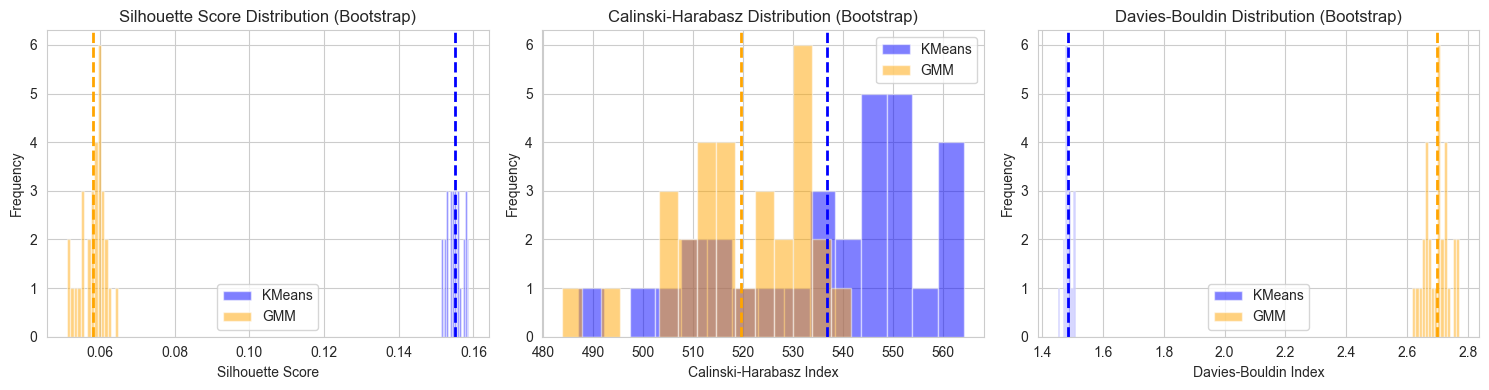


📊 Bootstrap distribution plot saved to: D:\docs\MADS\696-Milestone 2\unsupervised\bootstrap_metric_distributions.png


In [15]:
# --- Metric Stability Analysis: Bootstrap Resampling ---
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style('whitegrid')

N_BOOTSTRAP = 30  # Number of bootstrap samples
SAMPLE_SIZE = min(5000, len(X_full))  # Sample size for each bootstrap iteration

print(f"=== BOOTSTRAP STABILITY ANALYSIS ===")
print(f"Running {N_BOOTSTRAP} bootstrap iterations with sample size {SAMPLE_SIZE}...")

kmeans_sil_scores = []
gmm_sil_scores = []
kmeans_ch_scores = []
gmm_ch_scores = []
kmeans_db_scores = []
gmm_db_scores = []

np.random.seed(42)
for i in range(N_BOOTSTRAP):
    # Sample with replacement
    indices = np.random.choice(len(X_full), size=SAMPLE_SIZE, replace=True)
    X_boot = X_full[indices]
    
    # KMeans predictions
    labels_k = kmeans_best.predict(X_boot)
    metrics_k = compute_cluster_metrics(X_boot, labels_k)
    kmeans_sil_scores.append(metrics_k['silhouette'])
    kmeans_ch_scores.append(metrics_k['calinski_harabasz'])
    kmeans_db_scores.append(metrics_k['davies_bouldin'])
    
    # GMM predictions
    labels_g = gmm_best.predict(X_boot)
    metrics_g = compute_cluster_metrics(X_boot, labels_g)
    gmm_sil_scores.append(metrics_g['silhouette'])
    gmm_ch_scores.append(metrics_g['calinski_harabasz'])
    gmm_db_scores.append(metrics_g['davies_bouldin'])
    
    if (i + 1) % 10 == 0:
        print(f"  Completed {i + 1}/{N_BOOTSTRAP} iterations...")

# Calculate statistics
bootstrap_stats = pd.DataFrame({
    'Metric': ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'] * 2,
    'Model': ['KMeans']*3 + ['GMM']*3,
    'Mean': [
        np.mean(kmeans_sil_scores), np.mean(kmeans_ch_scores), np.mean(kmeans_db_scores),
        np.mean(gmm_sil_scores), np.mean(gmm_ch_scores), np.mean(gmm_db_scores)
    ],
    'Std': [
        np.std(kmeans_sil_scores), np.std(kmeans_ch_scores), np.std(kmeans_db_scores),
        np.std(gmm_sil_scores), np.std(gmm_ch_scores), np.std(gmm_db_scores)
    ],
    'Min': [
        np.min(kmeans_sil_scores), np.min(kmeans_ch_scores), np.min(kmeans_db_scores),
        np.min(gmm_sil_scores), np.min(gmm_ch_scores), np.min(gmm_db_scores)
    ],
    'Max': [
        np.max(kmeans_sil_scores), np.max(kmeans_ch_scores), np.max(kmeans_db_scores),
        np.max(gmm_sil_scores), np.max(gmm_ch_scores), np.max(gmm_db_scores)
    ],
    'CV': [
        np.std(kmeans_sil_scores)/np.mean(kmeans_sil_scores),
        np.std(kmeans_ch_scores)/np.mean(kmeans_ch_scores),
        np.std(kmeans_db_scores)/np.mean(kmeans_db_scores),
        np.std(gmm_sil_scores)/np.mean(gmm_sil_scores),
        np.std(gmm_ch_scores)/np.mean(gmm_ch_scores),
        np.std(gmm_db_scores)/np.mean(gmm_db_scores)
    ]
})

print("\n=== BOOTSTRAP METRIC STABILITY ===")
display(bootstrap_stats.round(4))

# Statistical significance tests
print("\n=== STATISTICAL SIGNIFICANCE TESTS (Mann-Whitney U) ===")
sil_stat, sil_pval = stats.mannwhitneyu(kmeans_sil_scores, gmm_sil_scores, alternative='two-sided')
ch_stat, ch_pval = stats.mannwhitneyu(kmeans_ch_scores, gmm_ch_scores, alternative='two-sided')
db_stat, db_pval = stats.mannwhitneyu(kmeans_db_scores, gmm_db_scores, alternative='two-sided')

print(f"Silhouette Score: U={sil_stat:.2f}, p-value={sil_pval:.4f} {'***' if sil_pval < 0.001 else '**' if sil_pval < 0.01 else '*' if sil_pval < 0.05 else 'ns'}")
print(f"Calinski-Harabasz: U={ch_stat:.2f}, p-value={ch_pval:.4f} {'***' if ch_pval < 0.001 else '**' if ch_pval < 0.01 else '*' if ch_pval < 0.05 else 'ns'}")
print(f"Davies-Bouldin: U={db_stat:.2f}, p-value={db_pval:.4f} {'***' if db_pval < 0.001 else '**' if db_pval < 0.01 else '*' if db_pval < 0.05 else 'ns'}")

# Visualize bootstrap distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(kmeans_sil_scores, alpha=0.5, bins=15, label='KMeans', color='blue')
axes[0].hist(gmm_sil_scores, alpha=0.5, bins=15, label='GMM', color='orange')
axes[0].set_xlabel('Silhouette Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Silhouette Score Distribution (Bootstrap)')
axes[0].legend()
axes[0].axvline(np.mean(kmeans_sil_scores), color='blue', linestyle='--', linewidth=2)
axes[0].axvline(np.mean(gmm_sil_scores), color='orange', linestyle='--', linewidth=2)

axes[1].hist(kmeans_ch_scores, alpha=0.5, bins=15, label='KMeans', color='blue')
axes[1].hist(gmm_ch_scores, alpha=0.5, bins=15, label='GMM', color='orange')
axes[1].set_xlabel('Calinski-Harabasz Index')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Calinski-Harabasz Distribution (Bootstrap)')
axes[1].legend()
axes[1].axvline(np.mean(kmeans_ch_scores), color='blue', linestyle='--', linewidth=2)
axes[1].axvline(np.mean(gmm_ch_scores), color='orange', linestyle='--', linewidth=2)

axes[2].hist(kmeans_db_scores, alpha=0.5, bins=15, label='KMeans', color='blue')
axes[2].hist(gmm_db_scores, alpha=0.5, bins=15, label='GMM', color='orange')
axes[2].set_xlabel('Davies-Bouldin Index')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Davies-Bouldin Distribution (Bootstrap)')
axes[2].legend()
axes[2].axvline(np.mean(kmeans_db_scores), color='blue', linestyle='--', linewidth=2)
axes[2].axvline(np.mean(gmm_db_scores), color='orange', linestyle='--', linewidth=2)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'bootstrap_metric_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Bootstrap distribution plot saved to: {MODEL_DIR / 'bootstrap_metric_distributions.png'}")

## 12. Cluster Quality Deep Dive
Analyze within-cluster cohesion, between-cluster separation, and silhouette analysis per cluster.

=== PER-CLUSTER SILHOUETTE ANALYSIS ===

KMeans - Per-Cluster Silhouette Scores:


,Cluster,Size,Mean_Silhouette,Std_Silhouette,Min_Silhouette,Max_Silhouette,Pct_Negative
0,0,1017,0.1112,0.1021,-0.1099,0.3478,14.6509
1,1,988,0.0808,0.1312,-0.1924,0.3111,31.6802
2,2,1398,0.1141,0.1102,-0.1603,0.3597,16.3090
3,3,257,0.0762,0.1475,-0.1728,0.3563,36.5759
4,4,1338,-0.0411,0.0786,-0.2461,0.1376,66.0688
5,5,2087,0.1414,0.1171,-0.1196,0.3926,13.9435
6,6,134,0.7034,0.0614,0.2849,0.7639,0.0000
7,7,3030,0.2570,0.1306,0.0222,0.4759,0.0000
8,8,1271,0.0391,0.1022,-0.1819,0.3050,37.7655
9,9,1677,0.0998,0.1040,-0.1298,0.3456,20.9899



GMM - Per-Cluster Silhouette Scores:


,Cluster,Size,Mean_Silhouette,Std_Silhouette,Min_Silhouette,Max_Silhouette,Pct_Negative
0,0,5198,-0.0813,0.1578,-0.5858,0.1671,62.3509
1,1,6009,0.2483,0.0741,-0.0277,0.3880,0.0166
2,2,11831,0.0237,0.1217,-0.3440,0.2405,38.1794


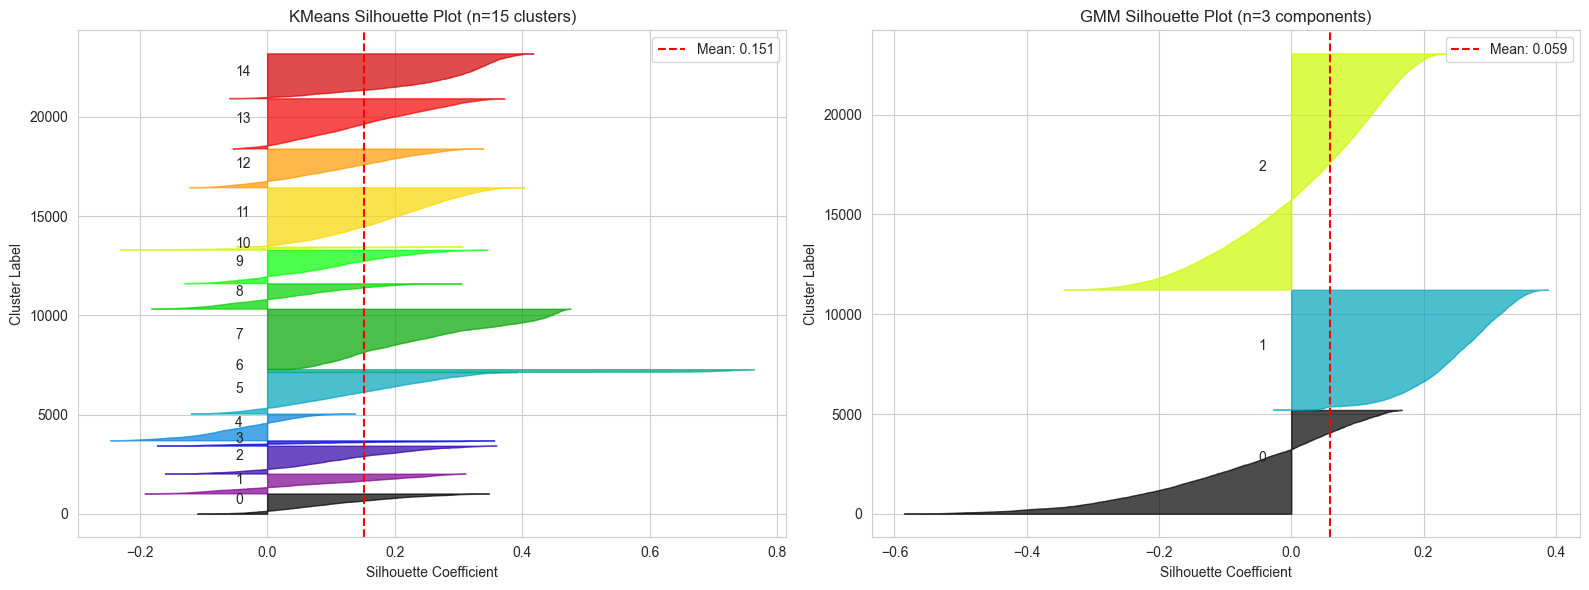


📊 Silhouette plots saved to: D:\docs\MADS\696-Milestone 2\unsupervised\silhouette_plots.png

=== POORLY CLUSTERED SAMPLES (Negative Silhouette) ===
KMeans: 3430 samples (14.89%)
GMM: 7759 samples (33.68%)


In [16]:
# --- Per-Cluster Silhouette Analysis ---
from sklearn.metrics import silhouette_samples
from scipy.spatial.distance import cdist

print("=== PER-CLUSTER SILHOUETTE ANALYSIS ===\n")

# Calculate silhouette scores for each sample
silhouette_kmeans = silhouette_samples(X_full, labels_kmeans)
silhouette_gmm = silhouette_samples(X_full, labels_gmm)

# KMeans per-cluster analysis
kmeans_cluster_silhouettes = []
for i in range(best_kmeans_params['kmeans_n_clusters']):
    cluster_mask = labels_kmeans == i
    cluster_sil = silhouette_kmeans[cluster_mask]
    kmeans_cluster_silhouettes.append({
        'Cluster': i,
        'Size': cluster_mask.sum(),
        'Mean_Silhouette': cluster_sil.mean(),
        'Std_Silhouette': cluster_sil.std(),
        'Min_Silhouette': cluster_sil.min(),
        'Max_Silhouette': cluster_sil.max(),
        'Pct_Negative': (cluster_sil < 0).sum() / len(cluster_sil) * 100
    })

kmeans_sil_df = pd.DataFrame(kmeans_cluster_silhouettes)
print("KMeans - Per-Cluster Silhouette Scores:")
display(kmeans_sil_df.round(4))

# GMM per-cluster analysis
gmm_cluster_silhouettes = []
for i in range(best_gmm_params['gmm_n_components']):
    cluster_mask = labels_gmm == i
    cluster_sil = silhouette_gmm[cluster_mask]
    gmm_cluster_silhouettes.append({
        'Cluster': i,
        'Size': cluster_mask.sum(),
        'Mean_Silhouette': cluster_sil.mean(),
        'Std_Silhouette': cluster_sil.std(),
        'Min_Silhouette': cluster_sil.min(),
        'Max_Silhouette': cluster_sil.max(),
        'Pct_Negative': (cluster_sil < 0).sum() / len(cluster_sil) * 100
    })

gmm_sil_df = pd.DataFrame(gmm_cluster_silhouettes)
print("\nGMM - Per-Cluster Silhouette Scores:")
display(gmm_sil_df.round(4))

# Visualize silhouette plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# KMeans silhouette plot
y_lower = 10
for i in range(best_kmeans_params['kmeans_n_clusters']):
    cluster_sil_values = silhouette_kmeans[labels_kmeans == i]
    cluster_sil_values.sort()
    
    size_cluster_i = cluster_sil_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / best_kmeans_params['kmeans_n_clusters'])
    axes[0].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
    axes[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

axes[0].set_xlabel('Silhouette Coefficient')
axes[0].set_ylabel('Cluster Label')
axes[0].set_title(f'KMeans Silhouette Plot (n={best_kmeans_params["kmeans_n_clusters"]} clusters)')
axes[0].axvline(x=silhouette_kmeans.mean(), color="red", linestyle="--", label=f'Mean: {silhouette_kmeans.mean():.3f}')
axes[0].legend()

# GMM silhouette plot
y_lower = 10
for i in range(best_gmm_params['gmm_n_components']):
    cluster_sil_values = silhouette_gmm[labels_gmm == i]
    cluster_sil_values.sort()
    
    size_cluster_i = cluster_sil_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / best_gmm_params['gmm_n_components'])
    axes[1].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
    axes[1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

axes[1].set_xlabel('Silhouette Coefficient')
axes[1].set_ylabel('Cluster Label')
axes[1].set_title(f'GMM Silhouette Plot (n={best_gmm_params["gmm_n_components"]} components)')
axes[1].axvline(x=silhouette_gmm.mean(), color="red", linestyle="--", label=f'Mean: {silhouette_gmm.mean():.3f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(MODEL_DIR / 'silhouette_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Silhouette plots saved to: {MODEL_DIR / 'silhouette_plots.png'}")

# Identify poorly clustered samples
kmeans_poorly_clustered = (silhouette_kmeans < 0).sum()
gmm_poorly_clustered = (silhouette_gmm < 0).sum()

print(f"\n=== POORLY CLUSTERED SAMPLES (Negative Silhouette) ===")
print(f"KMeans: {kmeans_poorly_clustered} samples ({kmeans_poorly_clustered/len(X_full)*100:.2f}%)")
print(f"GMM: {gmm_poorly_clustered} samples ({gmm_poorly_clustered/len(X_full)*100:.2f}%)")

=== INTRA-CLUSTER AND INTER-CLUSTER DISTANCE ANALYSIS ===

KMeans - Cluster Compactness (Distance to Center):


,Cluster,Mean_Distance_to_Center,Std_Distance,Max_Distance,Radius_95pct
0,0,6.7249,1.3978,13.9369,9.2063
1,1,7.3732,1.3112,11.9839,10.1180
2,2,5.2067,1.1798,10.8755,7.4313
3,3,7.0040,2.2635,19.7960,10.4249
4,4,14.6334,1.7374,34.1773,17.4913
5,5,8.8110,0.7144,10.3514,9.8205
6,6,14.9472,0.3162,17.1717,15.3689
7,7,4.8879,0.4717,6.2147,5.5860
8,8,4.5191,1.0954,13.6676,6.5177
9,9,12.9466,0.6580,14.5240,13.6625



KMeans - Inter-cluster distances (center-to-center):
  Mean: 7.6892
  Min: 2.2844
  Max: 19.3274
  Separation Ratio (inter/intra): 1.1624

GMM - Cluster Compactness (Distance to Empirical Center):


,Cluster,Mean_Distance_to_Center,Std_Distance,Max_Distance,Radius_95pct
0,0,4.6727,2.3303,55.9330,8.0052
1,1,2.6248,1.7850,16.6887,3.9646
2,2,3.3383,0.9130,8.8370,4.8955



GMM - Inter-cluster distances (center-to-center):
  Mean: 3.3445
  Min: 2.5714
  Max: 4.7064
  Separation Ratio (inter/intra): 0.9685


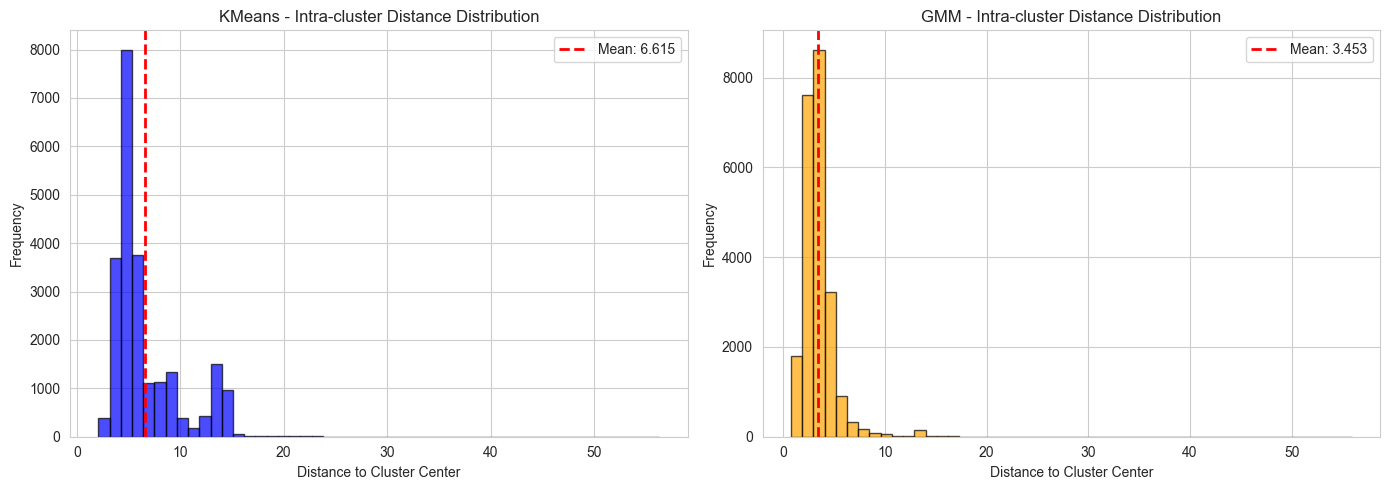


📊 Distance distribution plots saved to: D:\docs\MADS\696-Milestone 2\unsupervised\distance_distributions.png


In [22]:
# --- Intra-cluster & Inter-cluster Distance Analysis ---

print("=== INTRA-CLUSTER AND INTER-CLUSTER DISTANCE ANALYSIS ===\n")

# KMeans analysis
kmeans_centers = kmeans_best.cluster_centers_
kmeans_intra_distances = []
kmeans_cluster_compactness = []

for i in range(best_kmeans_params['kmeans_n_clusters']):
    cluster_points = X_full[labels_kmeans == i]
    center = kmeans_centers[i]
    # Calculate distances to cluster center
    distances = np.linalg.norm(cluster_points - center, axis=1)
    kmeans_intra_distances.extend(distances)
    kmeans_cluster_compactness.append({
        'Cluster': i,
        'Mean_Distance_to_Center': distances.mean(),
        'Std_Distance': distances.std(),
        'Max_Distance': distances.max(),
        'Radius_95pct': np.percentile(distances, 95)
    })

# Inter-cluster distances (center-to-center)
kmeans_inter_distances = cdist(kmeans_centers, kmeans_centers, metric='euclidean')
np.fill_diagonal(kmeans_inter_distances, np.nan)  # Ignore self-distances

kmeans_compactness_df = pd.DataFrame(kmeans_cluster_compactness)
print("KMeans - Cluster Compactness (Distance to Center):")
display(kmeans_compactness_df.round(4))

print(f"\nKMeans - Inter-cluster distances (center-to-center):")
print(f"  Mean: {np.nanmean(kmeans_inter_distances):.4f}")
print(f"  Min: {np.nanmin(kmeans_inter_distances):.4f}")
print(f"  Max: {np.nanmax(kmeans_inter_distances):.4f}")
print(f"  Separation Ratio (inter/intra): {np.nanmean(kmeans_inter_distances) / np.mean(kmeans_intra_distances):.4f}")

# GMM analysis - use predicted cluster centers (mean of each component)
gmm_cluster_compactness = []
gmm_intra_distances = []

for i in range(best_gmm_params['gmm_n_components']):
    cluster_points = X_full[labels_gmm == i]
    center = cluster_points.mean(axis=0)  # Empirical center
    distances = np.linalg.norm(cluster_points - center, axis=1)
    gmm_intra_distances.extend(distances)
    gmm_cluster_compactness.append({
        'Cluster': i,
        'Mean_Distance_to_Center': distances.mean(),
        'Std_Distance': distances.std(),
        'Max_Distance': distances.max(),
        'Radius_95pct': np.percentile(distances, 95)
    })

# GMM inter-cluster distances
gmm_centers = np.array([X_full[labels_gmm == i].mean(axis=0) for i in range(best_gmm_params['gmm_n_components'])])
gmm_inter_distances = cdist(gmm_centers, gmm_centers, metric='euclidean')
np.fill_diagonal(gmm_inter_distances, np.nan)

gmm_compactness_df = pd.DataFrame(gmm_cluster_compactness)
print("\nGMM - Cluster Compactness (Distance to Empirical Center):")
display(gmm_compactness_df.round(4))

print(f"\nGMM - Inter-cluster distances (center-to-center):")
print(f"  Mean: {np.nanmean(gmm_inter_distances):.4f}")
print(f"  Min: {np.nanmin(gmm_inter_distances):.4f}")
print(f"  Max: {np.nanmax(gmm_inter_distances):.4f}")
print(f"  Separation Ratio (inter/intra): {np.nanmean(gmm_inter_distances) / np.mean(gmm_intra_distances):.4f}")

# Visualize distance distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(kmeans_intra_distances, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_xlabel('Distance to Cluster Center')
axes[0].set_ylabel('Frequency')
axes[0].set_title('KMeans - Intra-cluster Distance Distribution')
axes[0].axvline(np.mean(kmeans_intra_distances), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(kmeans_intra_distances):.3f}')
axes[0].legend()

axes[1].hist(gmm_intra_distances, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1].set_xlabel('Distance to Cluster Center')
axes[1].set_ylabel('Frequency')
axes[1].set_title('GMM - Intra-cluster Distance Distribution')
axes[1].axvline(np.mean(gmm_intra_distances), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(gmm_intra_distances):.3f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(MODEL_DIR / 'distance_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Distance distribution plots saved to: {MODEL_DIR / 'distance_distributions.png'}")

## 13. Feature Importance & Cluster Characterization
Identify which features drive cluster separation and characterize each cluster.

=== FEATURE IMPORTANCE FOR CLUSTER SEPARATION ===

Top 20 Most Important Features for Cluster Separation:


c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning:

Features [13 19] are constant.

c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in divide

c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning:

Features [13 19] are constant.

c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in divide



,Feature,KMeans_F_Stat,KMeans_P_Value,GMM_F_Stat,GMM_P_Value,KMeans_Rank,GMM_Rank,Avg_Rank
16,hhi_150k_200k,4.222699e+03,0.0,6021.814148,0.000000e+00,3.0,2.0,2.5
15,total_pop,3.460800e+03,0.0,6539.817409,0.000000e+00,4.0,1.0,2.5
17,hhi_220k_plus,5.034288e+03,0.0,5730.538333,0.000000e+00,2.0,3.0,2.5
12,total_10_14,2.741752e+03,0.0,4785.011361,0.000000e+00,5.0,5.0,5.0
10,pct_hhi_220k_plus,2.653266e+03,0.0,5269.247091,0.000000e+00,6.0,4.0,5.0
1,enrollment,1.887953e+03,0.0,3202.561052,0.000000e+00,10.0,7.0,8.5
2,grade_eight_enrollment,1.916048e+03,0.0,2907.882752,0.000000e+00,9.0,9.0,9.0
14,pct_female_10_14,4.005393e+17,0.0,194.177775,2.358586e-84,1.0,18.0,9.5
0,teachers_fte,1.527735e+03,0.0,3196.480002,0.000000e+00,14.0,8.0,11.0
11,avg_natwalkind,1.363967e+03,0.0,4095.467843,0.000000e+00,16.0,6.0,11.0



Bottom 10 Least Important Features:


,Feature,KMeans_F_Stat,KMeans_P_Value,GMM_F_Stat,GMM_P_Value,KMeans_Rank,GMM_Rank,Avg_Rank
18,schools_in_zip,1625.723018,0.0,1695.174638,0.000000e+00,13.0,11.0,12.0
7,read_high_pct,2379.416134,0.0,279.692215,9.608249e-121,7.0,17.0,12.0
5,math_low_pct,1818.023783,0.0,566.896783,4.646667e-241,12.0,12.0,12.0
4,math_high_pct,2368.780595,0.0,291.540785,9.149439e-126,8.0,16.0,12.0
6,read_counts,1831.601200,0.0,413.507759,3.668481e-177,11.0,15.0,13.0
9,pct_hhi_150k_200k,1276.333110,0.0,2376.533701,0.000000e+00,18.0,10.0,14.0
8,read_low_pct,1433.125978,0.0,475.201165,5.842830e-203,15.0,14.0,14.5
3,math_counts,1313.076627,0.0,477.500078,6.424967e-204,17.0,13.0,15.0
13,pct_10_14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,dup_rank,NaN,NaN,NaN,NaN,NaN,NaN,NaN


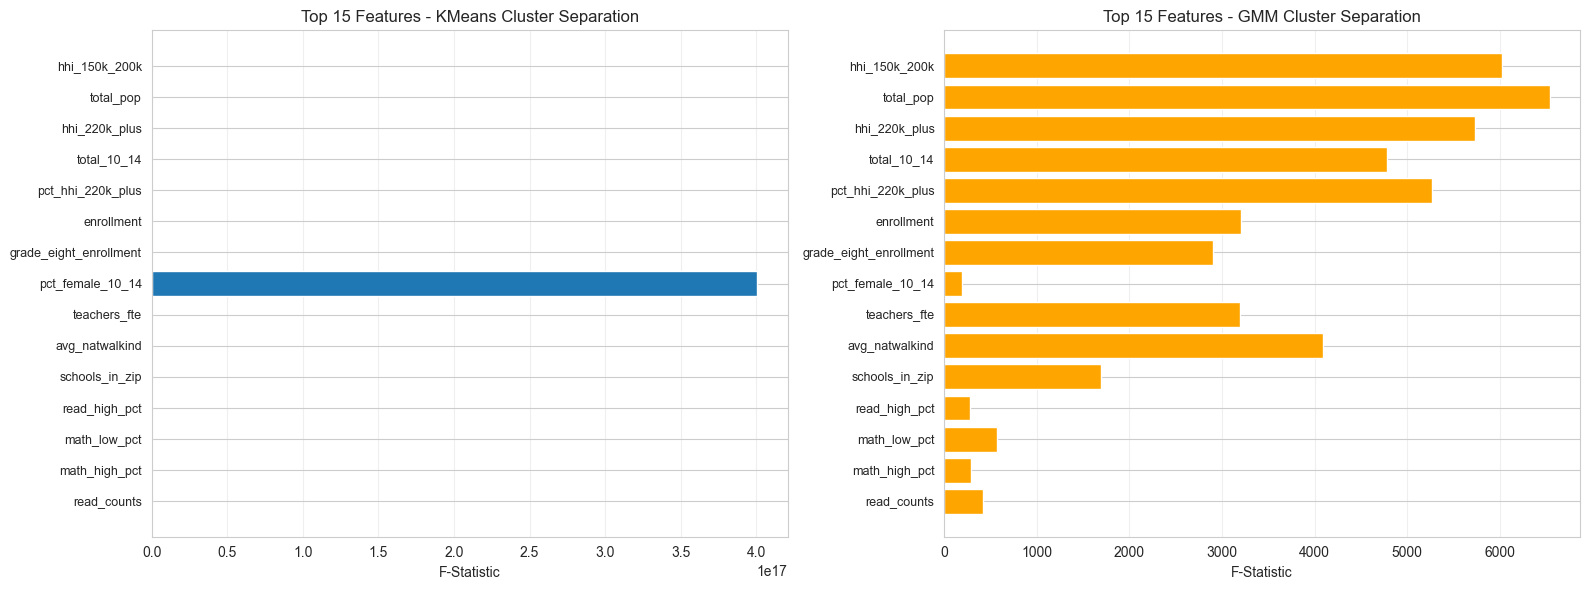


📊 Feature importance plot saved to: D:\docs\MADS\696-Milestone 2\unsupervised\feature_importance.png
💾 Feature importance saved to: D:\docs\MADS\696-Milestone 2\unsupervised\feature_importance.csv


In [23]:
# --- Feature Importance via ANOVA F-statistic ---
from sklearn.feature_selection import f_classif

print("=== FEATURE IMPORTANCE FOR CLUSTER SEPARATION ===\n")

# Calculate F-statistics for each feature across clusters
f_stats_kmeans, p_values_kmeans = f_classif(X_full, labels_kmeans)
f_stats_gmm, p_values_gmm = f_classif(X_full, labels_gmm)

# Create feature importance DataFrame
feature_names = df_numeric.columns.tolist()
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'KMeans_F_Stat': f_stats_kmeans,
    'KMeans_P_Value': p_values_kmeans,
    'GMM_F_Stat': f_stats_gmm,
    'GMM_P_Value': p_values_gmm
})

# Rank features
feature_importance['KMeans_Rank'] = feature_importance['KMeans_F_Stat'].rank(ascending=False)
feature_importance['GMM_Rank'] = feature_importance['GMM_F_Stat'].rank(ascending=False)
feature_importance['Avg_Rank'] = (feature_importance['KMeans_Rank'] + feature_importance['GMM_Rank']) / 2

# Sort by average rank
feature_importance = feature_importance.sort_values('Avg_Rank')

print("Top 20 Most Important Features for Cluster Separation:")
display(feature_importance.head(20))

print("\nBottom 10 Least Important Features:")
display(feature_importance.tail(10))

# Visualize top features
top_n = 15
top_features = feature_importance.head(top_n)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# KMeans feature importance
axes[0].barh(range(top_n), top_features['KMeans_F_Stat'].values)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top_features['Feature'].values, fontsize=9)
axes[0].invert_yaxis()
axes[0].set_xlabel('F-Statistic')
axes[0].set_title('Top 15 Features - KMeans Cluster Separation')
axes[0].grid(axis='x', alpha=0.3)

# GMM feature importance
axes[1].barh(range(top_n), top_features['GMM_F_Stat'].values, color='orange')
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels(top_features['Feature'].values, fontsize=9)
axes[1].invert_yaxis()
axes[1].set_xlabel('F-Statistic')
axes[1].set_title('Top 15 Features - GMM Cluster Separation')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Feature importance plot saved to: {MODEL_DIR / 'feature_importance.png'}")

# Save feature importance to CSV
feature_importance.to_csv(MODEL_DIR / 'feature_importance.csv', index=False)
print(f"💾 Feature importance saved to: {MODEL_DIR / 'feature_importance.csv'}")

=== CLUSTER CHARACTERIZATION ===

KMeans - Cluster Profiles (Top 10 Features):


hhi_150k_200k                                total_pop             \
                 mean       std  median   min   max       mean        std   
cluster                                                                     
0            2404.852   667.170  2291.0   803  6302  55109.450  16217.754   
1            1247.566   643.809  1106.0    52  3458  69508.297  17204.620   
2             974.853   472.168   962.5     8  2298  20118.049   9482.259   
3            3527.755  1106.982  3365.0  1317  7422  67847.163  21033.578   
4            1049.987   513.663   984.0    58  3903  41516.828  13277.958   
5             562.226   367.057   499.0     7  2137  33392.887  12625.899   
6              42.291   157.913     9.0     0  1694   1498.097   4576.727   
7              77.013   111.967    36.0     0   970   5026.500   5970.984   
8            1431.214   616.573  1401.0    14  3501  33342.593  15237.404   
9             783.397   422.373   739.0     0  2157  31362.127  13554.125   
10           1356.716   847.285  1348.0    19  4253  39471.232  20243.011   
11            240.604   200.401   184.0     0  1128  11804.613   8410.803   
12            427.610   340.102   344.0     0  2091  23983.537  13593.933   
13            154.526   203.001    76.0     0  1585   7071.676   8212.464   
14            249.218   292.440   127.0     0  1555  13195.690  13730.522   

                                 ... teachers_fte                        \
          median    min     max  ...         mean      std median   min   
cluster                          ...                                      
0        51995.0  23006  119994  ...       65.329   21.464   63.0   9.0   
1        69357.0  20243  130352  ...       39.321   21.275   36.5   0.0   
2        20248.0     55   54079  ...       51.740   20.759   49.0   0.0   
3        63916.0  31270  129165  ...       50.627   27.214   48.0   1.0   
4        40493.5   4806   90956  ...       54.887   19.851   53.0   1.0   
5        33058.0   1855   83858  ...       27.753   16.305   26.0   0.0   
6          600.0     27   51373  ...       18.954   22.730   13.0   0.0   
7         2624.5     35   34138  ...       17.213   11.213   15.0   0.0   
8        32605.0     82   84859  ...       39.546   27.329   34.0   0.0   
9        29880.0    555   80918  ...       57.028   20.343   54.0   9.0   
10       37818.0   1003  116469  ...      202.740  149.862  168.5  90.0   
11        9462.0     14   51253  ...       32.138   13.558   30.0   0.0   
12       22315.0    132   82706  ...       43.946   18.635   42.0   0.0   
13        3549.0      8   48518  ...       21.629   12.524   19.5   0.0   
14        7948.0     15   63835  ...       13.194   14.324    8.0   0.0   

                avg_natwalkind                                
            max           mean    std  median    min     max  
cluster                                                       
0         154.0         10.248  2.255  10.360  4.667  14.480  
1         127.0         12.337  2.131  13.348  5.419  14.832  
2         157.0         10.965  2.204  11.443  4.520  15.812  
3         203.0         12.135  2.113  13.097  5.852  15.228  
4         140.0          9.858  2.511  10.337  3.867  15.812  
5         121.0         11.335  2.283  11.731  3.433  15.228  
6         208.0          6.426  2.190   6.040  1.000  13.314  
7          93.0          6.237  1.601   6.055  1.000  13.497  
8         135.0         11.390  2.276  11.643  4.458  15.228  
9         149.0          9.229  2.511   9.116  2.867  14.832  
10       1700.0         11.161  2.290  11.691  5.000  14.832  
11        109.0          6.789  2.027   6.410  1.000  13.978  
12        155.0          9.204  2.716   9.138  2.250  15.228  
13         78.0          6.889  1.973   6.419  1.000  13.978  
14        112.0          7.524  2.508   6.767  1.000  15.228  

[15 rows x 50 columns]


GMM - Cluster Profiles (Top 10 Features):


hhi_150k_200k                              total_pop             \
                 mean       std  median min   max       mean        std   
cluster                                                                   
0            1329.231  1046.959  1105.0   0  7422  36258.690  23630.282   
1              55.470    63.405    35.0   0  1694   2758.396   2121.843   
2             622.289   498.045   487.0   0  2615  28419.677  17488.775   

                              ... teachers_fte                              \
          median min     max  ...         mean     std median  min     max   
cluster                       ...                                            
0        33111.0  20  130352  ...       57.921  44.797   52.0  0.0  1700.0   
1         2236.0   8   51373  ...       17.504  11.160   16.0  0.0   208.0   
2        25661.0  45  116469  ...       35.117  20.113   34.0  0.0   127.0   

        avg_natwalkind                              
                  mean    std  median  min     max  
cluster                                             
0               10.438  2.557  11.038  1.0  15.812  
1                6.284  1.553   6.094  1.0  13.497  
2                9.271  2.979   9.091  1.0  15.228  

[3 rows x 50 columns]


=== CLUSTER CENTER HEATMAPS ===


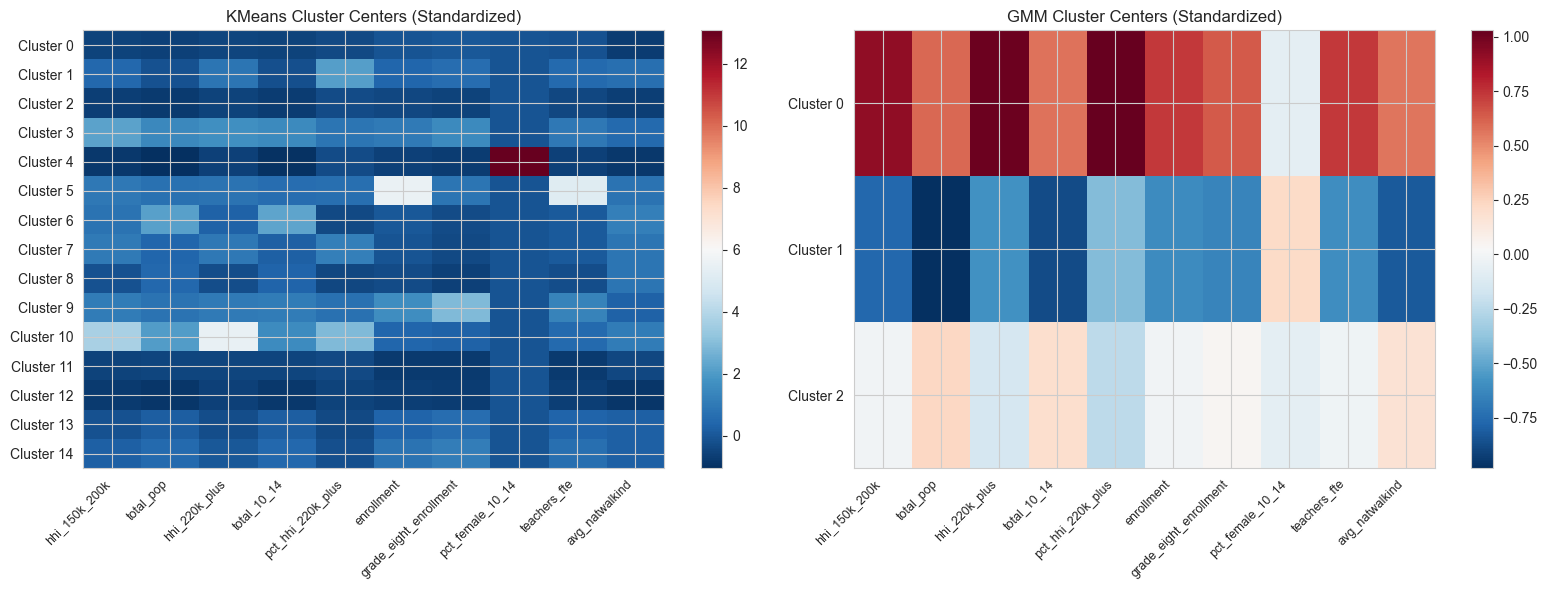


📊 Cluster center heatmaps saved to: D:\docs\MADS\696-Milestone 2\unsupervised\cluster_center_heatmaps.png

KMeans - Cluster Distinctiveness (Distance from other clusters):


,Cluster,Min_Distance_to_Other,Mean_Distance_to_Others
0,0,2.2844,5.9427
1,1,3.2990,6.3496
2,2,2.2844,6.2042
3,3,3.4658,6.6632
4,4,13.2111,14.5557
5,5,7.0663,9.3494
6,6,3.7215,7.0641
7,7,3.2866,5.9643
8,8,2.8196,5.9145
9,9,11.5757,13.5957



GMM - Cluster Distinctiveness (Distance from other clusters):


,Cluster,Min_Distance_to_Other,Mean_Distance_to_Others
0,0,2.7558,3.7311
1,1,2.5714,3.6389
2,2,2.5714,2.6636


In [24]:
# --- Cluster Characterization: Statistical Profiles ---

print("=== CLUSTER CHARACTERIZATION ===\n")

# Get top 10 most important features for detailed profiling
top_10_features = feature_importance.head(10)['Feature'].tolist()

# Add cluster labels to original numeric dataframe
profile_df_kmeans = df_numeric[top_10_features].copy()
profile_df_kmeans['cluster'] = labels_kmeans

profile_df_gmm = df_numeric[top_10_features].copy()
profile_df_gmm['cluster'] = labels_gmm

# KMeans cluster profiles
print("KMeans - Cluster Profiles (Top 10 Features):")
kmeans_profiles = profile_df_kmeans.groupby('cluster').agg(['mean', 'std', 'median', 'min', 'max'])
display(kmeans_profiles.round(3))

# GMM cluster profiles
print("\nGMM - Cluster Profiles (Top 10 Features):")
gmm_profiles = profile_df_gmm.groupby('cluster').agg(['mean', 'std', 'median', 'min', 'max'])
display(gmm_profiles.round(3))

# Create heatmap of cluster centers (standardized features)
print("\n=== CLUSTER CENTER HEATMAPS ===")

# KMeans centers for top features
top_feature_indices = [df_numeric.columns.get_loc(f) for f in top_10_features]
kmeans_centers_top = kmeans_centers[:, top_feature_indices]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# KMeans heatmap
im1 = axes[0].imshow(kmeans_centers_top, cmap='RdBu_r', aspect='auto', interpolation='nearest')
axes[0].set_xticks(range(len(top_10_features)))
axes[0].set_xticklabels(top_10_features, rotation=45, ha='right', fontsize=9)
axes[0].set_yticks(range(best_kmeans_params['kmeans_n_clusters']))
axes[0].set_yticklabels([f"Cluster {i}" for i in range(best_kmeans_params['kmeans_n_clusters'])])
axes[0].set_title('KMeans Cluster Centers (Standardized)')
plt.colorbar(im1, ax=axes[0])

# GMM centers (empirical) for top features
gmm_centers_top = gmm_centers[:, top_feature_indices]
im2 = axes[1].imshow(gmm_centers_top, cmap='RdBu_r', aspect='auto', interpolation='nearest')
axes[1].set_xticks(range(len(top_10_features)))
axes[1].set_xticklabels(top_10_features, rotation=45, ha='right', fontsize=9)
axes[1].set_yticks(range(best_gmm_params['gmm_n_components']))
axes[1].set_yticklabels([f"Cluster {i}" for i in range(best_gmm_params['gmm_n_components'])])
axes[1].set_title('GMM Cluster Centers (Standardized)')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.savefig(MODEL_DIR / 'cluster_center_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Cluster center heatmaps saved to: {MODEL_DIR / 'cluster_center_heatmaps.png'}")

# Identify most distinctive clusters (highest variance in features)
kmeans_cluster_distinctiveness = []
for i in range(best_kmeans_params['kmeans_n_clusters']):
    center_distances = np.linalg.norm(kmeans_centers - kmeans_centers[i], axis=1)
    center_distances[i] = np.inf  # Exclude self
    kmeans_cluster_distinctiveness.append({
        'Cluster': i,
        'Min_Distance_to_Other': center_distances.min(),
        'Mean_Distance_to_Others': center_distances[center_distances != np.inf].mean()
    })

kmeans_distinct_df = pd.DataFrame(kmeans_cluster_distinctiveness)
print("\nKMeans - Cluster Distinctiveness (Distance from other clusters):")
display(kmeans_distinct_df.round(4))

gmm_cluster_distinctiveness = []
for i in range(best_gmm_params['gmm_n_components']):
    center_distances = np.linalg.norm(gmm_centers - gmm_centers[i], axis=1)
    center_distances[i] = np.inf  # Exclude self
    gmm_cluster_distinctiveness.append({
        'Cluster': i,
        'Min_Distance_to_Other': center_distances.min(),
        'Mean_Distance_to_Others': center_distances[center_distances != np.inf].mean()
    })

gmm_distinct_df = pd.DataFrame(gmm_cluster_distinctiveness)
print("\nGMM - Cluster Distinctiveness (Distance from other clusters):")
display(gmm_distinct_df.round(4))

## 14. Cluster Agreement & Overlap Analysis
Compare cluster assignments between KMeans and GMM to understand model agreement.

=== CLUSTER AGREEMENT BETWEEN KMEANS AND GMM ===

Adjusted Rand Index (ARI): 0.0826
  Interpretation: 0.0826 (Low agreement)

Normalized Mutual Information (NMI): 0.2112
  Interpretation: 0.2112 (Low agreement)

Fowlkes-Mallows Index (FMI): 0.2755
  Interpretation: 0.2755 (Low agreement)

=== CONTINGENCY TABLE (Sample Overlap) ===
Rows: KMeans clusters, Columns: GMM clusters


,GMM_0,GMM_1,GMM_2
KMeans_0,879,0,138
KMeans_1,287,0,701
KMeans_2,1028,13,357
KMeans_3,257,0,0
KMeans_4,400,0,938
KMeans_5,144,1,1942
KMeans_6,0,134,0
KMeans_7,92,2194,744
KMeans_8,636,10,625
KMeans_9,489,0,1188


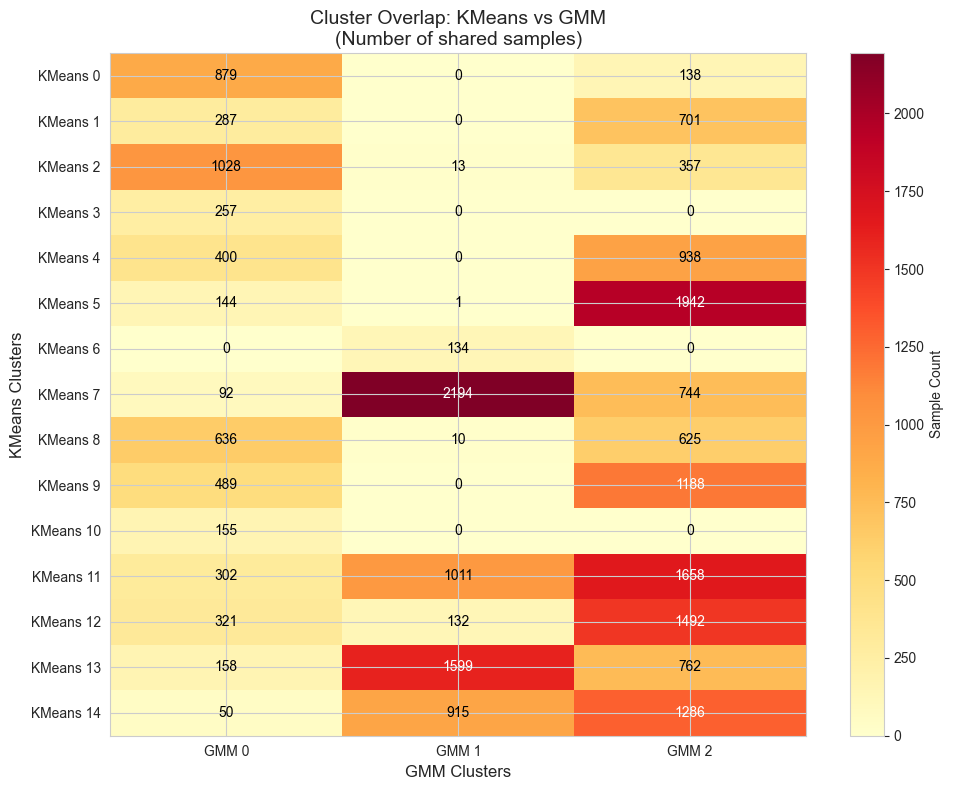


📊 Cluster agreement heatmap saved to: D:\docs\MADS\696-Milestone 2\unsupervised\cluster_agreement_heatmap.png

=== CLUSTER ASSIGNMENT DISAGREEMENT ===
Samples with different cluster assignments: 21802 (94.63%)
Samples with same cluster assignments: 1236 (5.37%)

Disagreement Sample Statistics:
  Mean KMeans Silhouette: 0.1544
  Mean GMM Silhouette: 0.0585
  Samples with negative silhouette in both: 1269

Top 10 most common disagreement patterns:


KMeans_Cluster  GMM_Cluster
7               1              2194
5               2              1942
11              2              1658
13              1              1599
12              2              1492
14              2              1286
9               2              1188
2               0              1028
11              1              1011
4               2               938
dtype: int64

In [25]:
# --- Cluster Agreement Analysis ---
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.metrics.cluster import contingency_matrix

print("=== CLUSTER AGREEMENT BETWEEN KMEANS AND GMM ===\n")

# Calculate agreement metrics
ari = adjusted_rand_score(labels_kmeans, labels_gmm)
nmi = normalized_mutual_info_score(labels_kmeans, labels_gmm)
fmi = fowlkes_mallows_score(labels_kmeans, labels_gmm)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"  Interpretation: {ari:.4f} {'(Perfect agreement)' if ari > 0.9 else '(High agreement)' if ari > 0.7 else '(Moderate agreement)' if ari > 0.4 else '(Low agreement)'}")
print(f"\nNormalized Mutual Information (NMI): {nmi:.4f}")
print(f"  Interpretation: {nmi:.4f} {'(Perfect agreement)' if nmi > 0.9 else '(High agreement)' if nmi > 0.7 else '(Moderate agreement)' if nmi > 0.4 else '(Low agreement)'}")
print(f"\nFowlkes-Mallows Index (FMI): {fmi:.4f}")
print(f"  Interpretation: {fmi:.4f} {'(Perfect agreement)' if fmi > 0.9 else '(High agreement)' if fmi > 0.7 else '(Moderate agreement)' if fmi > 0.4 else '(Low agreement)'}")

# Create contingency matrix
contingency = contingency_matrix(labels_kmeans, labels_gmm)
contingency_df = pd.DataFrame(
    contingency,
    index=[f'KMeans_{i}' for i in range(best_kmeans_params['kmeans_n_clusters'])],
    columns=[f'GMM_{i}' for i in range(best_gmm_params['gmm_n_components'])]
)

print("\n=== CONTINGENCY TABLE (Sample Overlap) ===")
print("Rows: KMeans clusters, Columns: GMM clusters")
display(contingency_df)

# Visualize contingency matrix as heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(contingency, cmap='YlOrRd', aspect='auto')

# Add text annotations
for i in range(contingency.shape[0]):
    for j in range(contingency.shape[1]):
        text = ax.text(j, i, contingency[i, j],
                      ha="center", va="center", color="black" if contingency[i, j] < contingency.max()/2 else "white")

ax.set_xticks(range(best_gmm_params['gmm_n_components']))
ax.set_yticks(range(best_kmeans_params['kmeans_n_clusters']))
ax.set_xticklabels([f'GMM {i}' for i in range(best_gmm_params['gmm_n_components'])])
ax.set_yticklabels([f'KMeans {i}' for i in range(best_kmeans_params['kmeans_n_clusters'])])
ax.set_xlabel('GMM Clusters', fontsize=12)
ax.set_ylabel('KMeans Clusters', fontsize=12)
ax.set_title('Cluster Overlap: KMeans vs GMM\n(Number of shared samples)', fontsize=14)
plt.colorbar(im, ax=ax, label='Sample Count')

plt.tight_layout()
plt.savefig(MODEL_DIR / 'cluster_agreement_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Cluster agreement heatmap saved to: {MODEL_DIR / 'cluster_agreement_heatmap.png'}")

# Identify samples with different cluster assignments
disagreement_mask = labels_kmeans != labels_gmm
n_disagreements = disagreement_mask.sum()
pct_disagreement = (n_disagreements / len(labels_kmeans)) * 100

print(f"\n=== CLUSTER ASSIGNMENT DISAGREEMENT ===")
print(f"Samples with different cluster assignments: {n_disagreements} ({pct_disagreement:.2f}%)")
print(f"Samples with same cluster assignments: {len(labels_kmeans) - n_disagreements} ({100 - pct_disagreement:.2f}%)")

# For disagreeing samples, analyze their characteristics
if n_disagreements > 0:
    disagreement_analysis = pd.DataFrame({
        'KMeans_Cluster': labels_kmeans[disagreement_mask],
        'GMM_Cluster': labels_gmm[disagreement_mask],
        'KMeans_Silhouette': silhouette_kmeans[disagreement_mask],
        'GMM_Silhouette': silhouette_gmm[disagreement_mask]
    })
    
    print("\nDisagreement Sample Statistics:")
    print(f"  Mean KMeans Silhouette: {disagreement_analysis['KMeans_Silhouette'].mean():.4f}")
    print(f"  Mean GMM Silhouette: {disagreement_analysis['GMM_Silhouette'].mean():.4f}")
    print(f"  Samples with negative silhouette in both: {((disagreement_analysis['KMeans_Silhouette'] < 0) & (disagreement_analysis['GMM_Silhouette'] < 0)).sum()}")
    
    print("\nTop 10 most common disagreement patterns:")
    disagreement_patterns = disagreement_analysis.groupby(['KMeans_Cluster', 'GMM_Cluster']).size().sort_values(ascending=False)
    display(disagreement_patterns.head(10))

## 15. Comprehensive Performance Report
Generate final summary report with all metrics and recommendations.

                    UNSUPERVISED CLUSTERING - FINAL REPORT

📊 KEY FINDINGS

1. Dataset: 23,038 samples, 20 features

2. Best Configurations:
   KMeans: 15 clusters
   GMM: 3 components

3. Performance Metrics:
   Metric                    KMeans          GMM            
   -------------------------------------------------------
   Silhouette Score          0.1515          0.0586         
   Calinski-Harabasz         2291.09         2367.53        
   Davies-Bouldin            1.5826          2.7110         

4. Stability (Bootstrap Analysis):
   KMeans Silhouette CV: 0.0134
   GMM Silhouette CV: 0.0552
   Statistical Significance: Yes (p=0.0000)

5. Cluster Quality:
   KMeans - Poorly clustered: 14.89%
   GMM - Poorly clustered: 33.68%
   KMeans Separation Ratio: 1.1624
   GMM Separation Ratio: 0.9685

6. Model Agreement:
   Adjusted Rand Index: 0.0826
   Normalized Mutual Info: 0.2112
   Disagreement Rate: 94.63%

7. Top 5 Most Important Features:
   1. hhi_150k_200k (KMeans F=4222.70

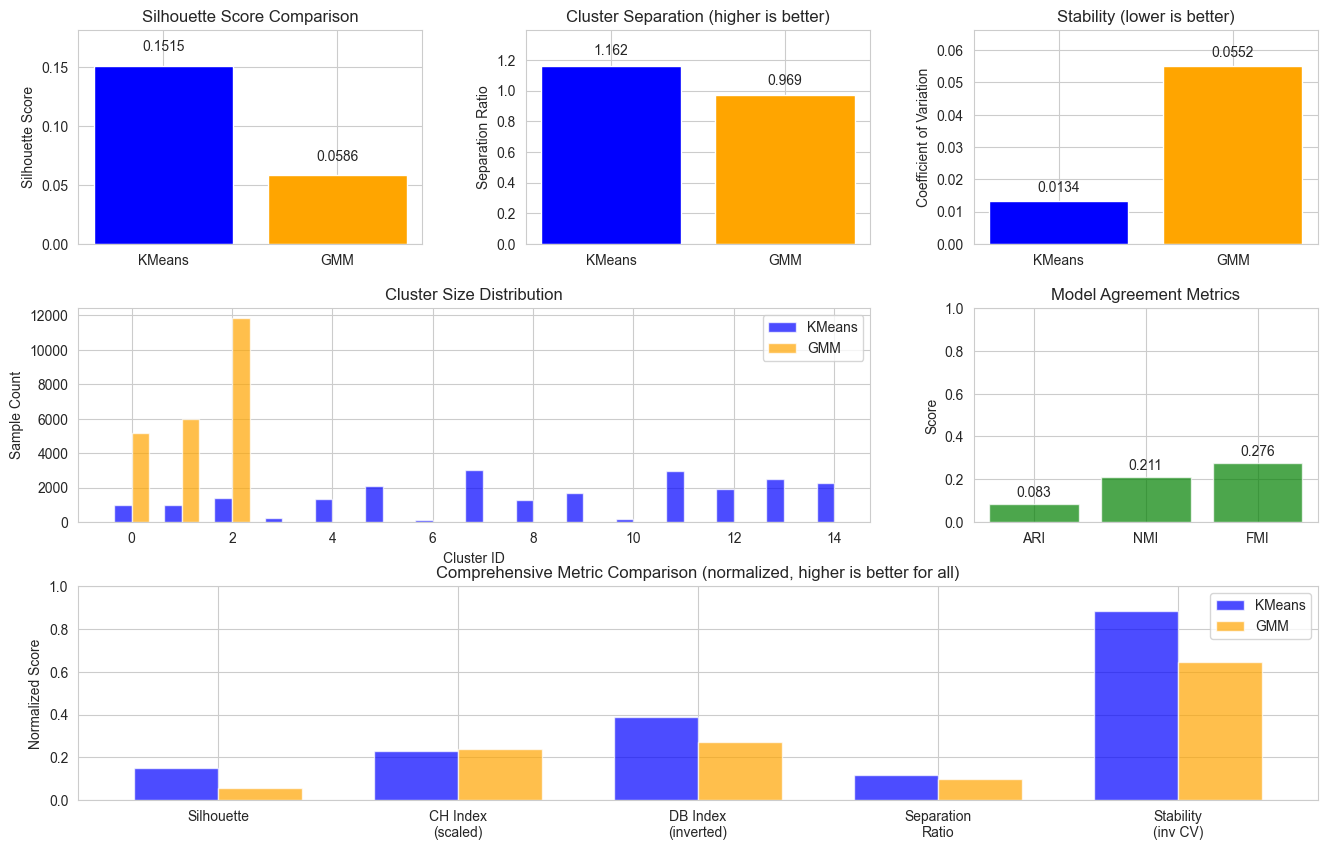

📊 Performance summary visualization saved to: D:\docs\MADS\696-Milestone 2\unsupervised\comprehensive_performance_summary.png

                         ANALYSIS COMPLETE


In [26]:
# --- Comprehensive Performance Report ---

print("="*80)
print(" " * 20 + "UNSUPERVISED CLUSTERING - FINAL REPORT")
print("="*80)

final_report = {
    'timestamp': datetime.utcnow().isoformat() + 'Z',
    'dataset_info': {
        'total_samples': len(X_full),
        'n_features': X_full.shape[1],
        'n_numeric_features': len(df_numeric.columns)
    },
    'optimization_summary': {
        'kmeans': {
            'n_trials': len(study_kmeans.trials),
            'best_n_clusters': best_kmeans_params['kmeans_n_clusters'],
            'best_silhouette': float(study_kmeans.best_value),
            'hyperparameters': best_kmeans_params
        },
        'gmm': {
            'n_trials': len(study_gmm.trials),
            'best_n_components': best_gmm_params['gmm_n_components'],
            'best_silhouette': float(study_gmm.best_value),
            'hyperparameters': best_gmm_params
        }
    },
    'final_metrics': {
        'kmeans': {
            'silhouette': float(kmeans_final_metrics['silhouette']),
            'calinski_harabasz': float(kmeans_final_metrics['calinski_harabasz']),
            'davies_bouldin': float(kmeans_final_metrics['davies_bouldin']),
            'inertia': float(kmeans_best.inertia_)
        },
        'gmm': {
            'silhouette': float(gmm_final_metrics['silhouette']),
            'calinski_harabasz': float(gmm_final_metrics['calinski_harabasz']),
            'davies_bouldin': float(gmm_final_metrics['davies_bouldin']),
            'aic': float(gmm_best.aic(X_full)),
            'bic': float(gmm_best.bic(X_full))
        }
    },
    'bootstrap_stability': {
        'kmeans': {
            'silhouette_mean': float(np.mean(kmeans_sil_scores)),
            'silhouette_std': float(np.std(kmeans_sil_scores)),
            'silhouette_cv': float(np.std(kmeans_sil_scores) / np.mean(kmeans_sil_scores))
        },
        'gmm': {
            'silhouette_mean': float(np.mean(gmm_sil_scores)),
            'silhouette_std': float(np.std(gmm_sil_scores)),
            'silhouette_cv': float(np.std(gmm_sil_scores) / np.mean(gmm_sil_scores))
        },
        'statistical_tests': {
            'mann_whitney_u': {
                'silhouette_pvalue': float(sil_pval),
                'significant': bool(sil_pval < 0.05)
            }
        }
    },
    'cluster_quality': {
        'kmeans': {
            'poorly_clustered_pct': float(kmeans_poorly_clustered / len(X_full) * 100),
            'mean_intra_distance': float(np.mean(kmeans_intra_distances)),
            'mean_inter_distance': float(np.nanmean(kmeans_inter_distances)),
            'separation_ratio': float(np.nanmean(kmeans_inter_distances) / np.mean(kmeans_intra_distances)),
            'cluster_balance_cv': float(kmeans_cv)
        },
        'gmm': {
            'poorly_clustered_pct': float(gmm_poorly_clustered / len(X_full) * 100),
            'mean_intra_distance': float(np.mean(gmm_intra_distances)),
            'mean_inter_distance': float(np.nanmean(gmm_inter_distances)),
            'separation_ratio': float(np.nanmean(gmm_inter_distances) / np.mean(gmm_intra_distances)),
            'cluster_balance_cv': float(gmm_cv)
        }
    },
    'model_agreement': {
        'adjusted_rand_index': float(ari),
        'normalized_mutual_info': float(nmi),
        'fowlkes_mallows_index': float(fmi),
        'disagreement_pct': float(pct_disagreement)
    },
    'top_features': feature_importance.head(10)[['Feature', 'KMeans_F_Stat', 'GMM_F_Stat']].to_dict('records')
}

# Print key findings
print("\n📊 KEY FINDINGS\n")
print(f"1. Dataset: {final_report['dataset_info']['total_samples']:,} samples, {final_report['dataset_info']['n_features']} features")
print(f"\n2. Best Configurations:")
print(f"   KMeans: {final_report['optimization_summary']['kmeans']['best_n_clusters']} clusters")
print(f"   GMM: {final_report['optimization_summary']['gmm']['best_n_components']} components")

print(f"\n3. Performance Metrics:")
print(f"   {'Metric':<25} {'KMeans':<15} {'GMM':<15}")
print(f"   {'-'*55}")
print(f"   {'Silhouette Score':<25} {final_report['final_metrics']['kmeans']['silhouette']:<15.4f} {final_report['final_metrics']['gmm']['silhouette']:<15.4f}")
print(f"   {'Calinski-Harabasz':<25} {final_report['final_metrics']['kmeans']['calinski_harabasz']:<15.2f} {final_report['final_metrics']['gmm']['calinski_harabasz']:<15.2f}")
print(f"   {'Davies-Bouldin':<25} {final_report['final_metrics']['kmeans']['davies_bouldin']:<15.4f} {final_report['final_metrics']['gmm']['davies_bouldin']:<15.4f}")

print(f"\n4. Stability (Bootstrap Analysis):")
print(f"   KMeans Silhouette CV: {final_report['bootstrap_stability']['kmeans']['silhouette_cv']:.4f}")
print(f"   GMM Silhouette CV: {final_report['bootstrap_stability']['gmm']['silhouette_cv']:.4f}")
print(f"   Statistical Significance: {'Yes' if final_report['bootstrap_stability']['statistical_tests']['mann_whitney_u']['significant'] else 'No'} (p={final_report['bootstrap_stability']['statistical_tests']['mann_whitney_u']['silhouette_pvalue']:.4f})")

print(f"\n5. Cluster Quality:")
print(f"   KMeans - Poorly clustered: {final_report['cluster_quality']['kmeans']['poorly_clustered_pct']:.2f}%")
print(f"   GMM - Poorly clustered: {final_report['cluster_quality']['gmm']['poorly_clustered_pct']:.2f}%")
print(f"   KMeans Separation Ratio: {final_report['cluster_quality']['kmeans']['separation_ratio']:.4f}")
print(f"   GMM Separation Ratio: {final_report['cluster_quality']['gmm']['separation_ratio']:.4f}")

print(f"\n6. Model Agreement:")
print(f"   Adjusted Rand Index: {final_report['model_agreement']['adjusted_rand_index']:.4f}")
print(f"   Normalized Mutual Info: {final_report['model_agreement']['normalized_mutual_info']:.4f}")
print(f"   Disagreement Rate: {final_report['model_agreement']['disagreement_pct']:.2f}%")

print(f"\n7. Top 5 Most Important Features:")
for i, feat in enumerate(final_report['top_features'][:5], 1):
    print(f"   {i}. {feat['Feature']} (KMeans F={feat['KMeans_F_Stat']:.2f}, GMM F={feat['GMM_F_Stat']:.2f})")

# Recommendations
print("\n\n🎯 RECOMMENDATIONS\n")
recommendations = []

if final_report['final_metrics']['kmeans']['silhouette'] > final_report['final_metrics']['gmm']['silhouette']:
    recommendations.append("✓ KMeans shows higher silhouette score - prefer for simpler, spherical clusters")
else:
    recommendations.append("✓ GMM shows higher silhouette score - prefer for complex, elliptical clusters")

if final_report['cluster_quality']['kmeans']['separation_ratio'] > final_report['cluster_quality']['gmm']['separation_ratio']:
    recommendations.append("✓ KMeans has better cluster separation")
else:
    recommendations.append("✓ GMM has better cluster separation")

if final_report['bootstrap_stability']['kmeans']['silhouette_cv'] < final_report['bootstrap_stability']['gmm']['silhouette_cv']:
    recommendations.append("✓ KMeans shows more stable clustering across resamples")
else:
    recommendations.append("✓ GMM shows more stable clustering across resamples")

if final_report['model_agreement']['adjusted_rand_index'] > 0.7:
    recommendations.append("✓ High agreement between models - robust clustering structure")
elif final_report['model_agreement']['adjusted_rand_index'] < 0.4:
    recommendations.append("⚠ Low agreement between models - consider data characteristics or try other algorithms")

if min(final_report['cluster_quality']['kmeans']['poorly_clustered_pct'], 
       final_report['cluster_quality']['gmm']['poorly_clustered_pct']) > 10:
    recommendations.append("⚠ High percentage of poorly clustered samples - consider feature engineering or outlier removal")

for i, rec in enumerate(recommendations, 1):
    print(f"   {i}. {rec}")

# Save comprehensive report
report_path = MODEL_DIR / 'comprehensive_performance_report.json'
with open(report_path, 'w') as f:
    json.dump(final_report, f, indent=2)

print(f"\n\n💾 Full report saved to: {report_path}")

# Create summary visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Silhouette comparison
ax1 = fig.add_subplot(gs[0, 0])
models = ['KMeans', 'GMM']
silhouettes = [final_report['final_metrics']['kmeans']['silhouette'], 
               final_report['final_metrics']['gmm']['silhouette']]
ax1.bar(models, silhouettes, color=['blue', 'orange'])
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score Comparison')
ax1.set_ylim([0, max(silhouettes) * 1.2])
for i, v in enumerate(silhouettes):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# Separation ratio comparison
ax2 = fig.add_subplot(gs[0, 1])
sep_ratios = [final_report['cluster_quality']['kmeans']['separation_ratio'],
              final_report['cluster_quality']['gmm']['separation_ratio']]
ax2.bar(models, sep_ratios, color=['blue', 'orange'])
ax2.set_ylabel('Separation Ratio')
ax2.set_title('Cluster Separation (higher is better)')
ax2.set_ylim([0, max(sep_ratios) * 1.2])
for i, v in enumerate(sep_ratios):
    ax2.text(i, v + 0.05, f'{v:.3f}', ha='center', va='bottom')

# Stability (CV) comparison
ax3 = fig.add_subplot(gs[0, 2])
cvs = [final_report['bootstrap_stability']['kmeans']['silhouette_cv'],
       final_report['bootstrap_stability']['gmm']['silhouette_cv']]
ax3.bar(models, cvs, color=['blue', 'orange'])
ax3.set_ylabel('Coefficient of Variation')
ax3.set_title('Stability (lower is better)')
ax3.set_ylim([0, max(cvs) * 1.2])
for i, v in enumerate(cvs):
    ax3.text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom')

# Cluster size distribution
ax4 = fig.add_subplot(gs[1, :2])
cluster_sizes_k = pd.Series(labels_kmeans).value_counts().sort_index()
cluster_sizes_g = pd.Series(labels_gmm).value_counts().sort_index()
x_k = np.arange(len(cluster_sizes_k))
x_g = np.arange(len(cluster_sizes_g))
width = 0.35
ax4.bar(x_k - width/2, cluster_sizes_k, width, label='KMeans', color='blue', alpha=0.7)
ax4.bar(x_g + width/2, cluster_sizes_g, width, label='GMM', color='orange', alpha=0.7)
ax4.set_xlabel('Cluster ID')
ax4.set_ylabel('Sample Count')
ax4.set_title('Cluster Size Distribution')
ax4.legend()

# Model agreement metrics
ax5 = fig.add_subplot(gs[1, 2])
agreement_metrics = ['ARI', 'NMI', 'FMI']
agreement_values = [final_report['model_agreement']['adjusted_rand_index'],
                    final_report['model_agreement']['normalized_mutual_info'],
                    final_report['model_agreement']['fowlkes_mallows_index']]
ax5.bar(agreement_metrics, agreement_values, color='green', alpha=0.7)
ax5.set_ylabel('Score')
ax5.set_title('Model Agreement Metrics')
ax5.set_ylim([0, 1])
for i, v in enumerate(agreement_values):
    ax5.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

# All metrics comparison (normalized)
ax6 = fig.add_subplot(gs[2, :])
metrics_names = ['Silhouette', 'CH Index\n(scaled)', 'DB Index\n(inverted)', 'Separation\nRatio', 'Stability\n(inv CV)']
# Normalize metrics to 0-1 range for comparison
kmeans_normalized = [
    final_report['final_metrics']['kmeans']['silhouette'],
    final_report['final_metrics']['kmeans']['calinski_harabasz'] / 10000,  # Scale down
    1 / (1 + final_report['final_metrics']['kmeans']['davies_bouldin']),  # Invert (lower is better)
    final_report['cluster_quality']['kmeans']['separation_ratio'] / 10,
    1 / (1 + final_report['bootstrap_stability']['kmeans']['silhouette_cv'] * 10)  # Invert
]
gmm_normalized = [
    final_report['final_metrics']['gmm']['silhouette'],
    final_report['final_metrics']['gmm']['calinski_harabasz'] / 10000,
    1 / (1 + final_report['final_metrics']['gmm']['davies_bouldin']),
    final_report['cluster_quality']['gmm']['separation_ratio'] / 10,
    1 / (1 + final_report['bootstrap_stability']['gmm']['silhouette_cv'] * 10)
]
x = np.arange(len(metrics_names))
width = 0.35
ax6.bar(x - width/2, kmeans_normalized, width, label='KMeans', color='blue', alpha=0.7)
ax6.bar(x + width/2, gmm_normalized, width, label='GMM', color='orange', alpha=0.7)
ax6.set_ylabel('Normalized Score')
ax6.set_title('Comprehensive Metric Comparison (normalized, higher is better for all)')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics_names)
ax6.legend()
ax6.set_ylim([0, 1])

plt.savefig(MODEL_DIR / 'comprehensive_performance_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"📊 Performance summary visualization saved to: {MODEL_DIR / 'comprehensive_performance_summary.png'}")

print("\n" + "="*80)
print(" " * 25 + "ANALYSIS COMPLETE")
print("="*80)